# Importing Libraries and Setting States

In [19]:
#Import relevant standard libraries for processing
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Imports sklearn related libraries
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import LeaveOneOut

from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator

import statsmodels.graphics.factorplots

In [20]:
random_state = 42

# Importing and Investigating Data File

In [21]:
#Specifiy the current concatenated csv to work from based on that exported in the first Jupyter notebook
working_file = './data/final_data/final_data_27Feb20_144315.csv'

In [22]:
#Read in the working csv file to a pandas dataframe
df_original = pd.read_csv(working_file)
#df_original

In [23]:
#Investigate head to see if data has been read in correctly. 
df_original.head(5)

original_video_id  OtherGestures  Smile  Laugh  Scowl  \
0  trial_lie_001.mp4              1      0      0      0   
1  trial_lie_002.mp4              1      0      0      0   
2  trial_lie_003.mp4              1      0      0      0   
3  trial_lie_005.mp4              1      0      0      0   
4  trial_lie_007.mp4              1      0      0      0   

   otherEyebrowMovement  Frown  Raise  OtherEyeMovements  Close-R  ...  \
0                     1      0      0                  1        0  ...   
1                     0      1      0                  1        0  ...   
2                     0      1      0                  0        1  ...   
3                     0      1      0                  1        0  ...   
4                     0      0      1                  1        0  ...   

   Jitter - local, absolute  Jitter - rap  Jitter - ppq5  Jitter - ddp  \
0                  0.000299      0.032612       0.031032      0.097837   
1                  0.000212      0.025659       0.023041      0.076978   
2                  0.000288      0.027463       0.024932      0.082389   
3                  0.000228      0.028416       0.024742      0.085249   
4                  0.000345      0.036348       0.036846      0.109044   

   target_dummy  Gender_dummy  pauses_per_minute  log_pauses_per_minute  \
0             1           0.0           2.550000               1.266948   
1             1           0.0          17.708333               2.928969   
2             1           1.0           0.000000               0.000000   
3             1           0.0          14.240000               2.723924   
4             1           0.0          11.325000               2.511630   

   diff_max_mix  diff_25_75  
0         323.0        78.0  
1         291.0        21.0  
2         138.0        78.0  
3         212.0        23.0  
4         201.0        22.0  

[5 rows x 67 columns]

In [24]:
#Lets also have a look at the variables. 
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 67 columns):
original_video_id                            109 non-null object
OtherGestures                                109 non-null int64
Smile                                        109 non-null int64
Laugh                                        109 non-null int64
Scowl                                        109 non-null int64
otherEyebrowMovement                         109 non-null int64
Frown                                        109 non-null int64
Raise                                        109 non-null int64
OtherEyeMovements                            109 non-null int64
Close-R                                      109 non-null int64
X-Open                                       109 non-null int64
Close-BE                                     109 non-null int64
gazeInterlocutor                             109 non-null int64
gazeDown                                     109 non-null int6

# Model 1 - Gestures
<left><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS3lLnguG1LeMhSV1i61GzUQdejdm2qXoB7GytsVnMO4ckBecsc" width="400" height="100"></left>


For the first individual model, I will look at the gesture features only to see how well they predict the target classes.

In [25]:
#So we have some key references as needed, I will create a list of the gesture variables in our data set
gesture_variables =     ['OtherGestures', 'Smile', 'Laugh', 'Scowl',\
                         'otherEyebrowMovement', 'Frown', 'Raise', 'OtherEyeMovements',\
                         'Close-R', 'X-Open', 'Close-BE', 'gazeInterlocutor', 'gazeDown',\
                         'gazeUp', 'gazeSide', 'openMouth', 'closeMouth', 'lipsDown', 'lipsUp',\
                         'lipsRetracted', 'lipsProtruded', 'SideTurn', 'downR', 'sideTilt',\
                         'otherHeadM', 'sideTurnR', 'sideTiltR', 'waggle', 'forwardHead',\
                         'downRHead', 'singleHand', 'bothHands', 'otherHandM', 'complexHandM',\
                         'sidewaysHand', 'downHands', 'upHands']

#Just in case they are needed I've also recreated the gestures variables for identification of how 
#specific features relate to overarching gesture categories as specified in the MUMIN coding scheme
#(Allwood et al., (2004). The MUMIN multimodal coding scheme. 
#https://www.researchgate.net/publication/228626291_The_MUMIN_multimodal_coding_scheme). 
general_face =          ['Smile', 'Laugh', 'Scowl', 'OtherGestures']
eyebrows =              ['Frown', 'Raise', 'otherEyebrowMovement']
eyes =                  ['X-Open', 'Close-BE', 'Close-R', 'OtherEyeMovements']
gaze =                  ['gazeInterlocutor', 'gazeDown', 'gazeUp', 'gazeSide']
mouth =                 ['openMouth', 'closeMouth']
lips =                  ['lipsDown', 'lipsUp', 'lipsRetracted', 'lipsProtruded', 'target']
head_movements =        ['SideTurn', 'downR', 'sideTilt', 'otherHeadM', 'sideTurnR', 'sideTiltR',
                         'waggle', 'forwardHead', 'downRHead']
hand_gestures =         ['singleHand', 'bothHands', 'otherHandM', 'complexHandM', 'sidewaysHand',
                         'downHands', 'upHands']

### Gesture Dimensionality Reduction - PCA
As we have a lot of gesture features (gestures feature n=36; note also we have lost two columns through during EDA 'otherGaze','backHead' as had no observations/variance) vs. the number target cases (n=109), we have issues of potentially high dimensionality, particularly when we come to fusing models later on. Therefore, I will first investigate whether there are opportunities for dimensionality reduction using PCA.

In [26]:
#This piece of code will output the PCA to a pandas table with conditional formatting to help identify
#features showing that have maximal data variance on the component.

#Specify the number of components to extract. In this case is using mle rather than a pre-specified value
n_components_output = 'mle'
#Initalise an empty PCA classifier
gesture_pca = PCA(n_components=n_components_output, random_state=random_state)
#Fit the PCA on the target data frame values 
gesture_pca.fit(df_original[gesture_variables])

n_components_found = len(gesture_pca.components_)

#Get the column names for use in labelling the index and help identify which features loading on each component
index_list = df_original[gesture_variables].columns
#Set the eigenvectors to highlight in the final output. This is for visual aid in identifying more important weightings
flag_value = 0.3

#Create an empty pricpals components list to append the names of each Principle component
principals_list=[]

#create names for each Principal compoenent
for pc in range(1,n_components_found+1):
    principals_list.append(str("Principal Component " + str(pc)))

#Create a Dataframe with eigenvectors for each component and append the names to the index
Factor_loadings = pd.DataFrame(data=gesture_pca.components_.T,columns=principals_list, index=index_list)

#THis piece of code obtains the eigenvectors and appends these to the bottom of the factor_loading table
eig_columns = ['Eigenvalue']
subj_exp_var_eigenvals = pd.DataFrame(gesture_pca.explained_variance_, columns=eig_columns,index=principals_list).T
Factor_loadings = Factor_loadings.append(subj_exp_var_eigenvals,)

#THis piece of code obtains the variance explained % for each component and appends this to the bottom of the factor_loading table
variance_explained_label = ['Variance Explained %']
subj_exp_var_pct = pd.DataFrame(gesture_pca.explained_variance_ratio_, columns=variance_explained_label,index=principals_list).T
Factor_loadings = Factor_loadings.append(subj_exp_var_pct)

cum_per = pd.DataFrame(subj_exp_var_pct.T.reset_index()['Variance Explained %'].cumsum())\
                .rename(columns={'Variance Explained %': 'Cumlative Variance Explained'}).T
cum_per.columns = principals_list
Factor_loadings = Factor_loadings.append(cum_per)

#Applying style to the pandas sheet based on the flag value. 
Factor_loadings.style.apply(lambda x: ["background: lightgreen" if v > flag_value 
                                       else "background: lightyellow" if v < (0-flag_value)
                                       else "" for v in x], axis=1,subset=pd.IndexSlice[index_list,principals_list]).set_precision(3)


We can use this informtion to help identify clusters of behaviours that may indicate deception or trutuful statements. To interpret each principal component, we can look at the size and the direction of each coefficiet of the original features fed into the PCA. Larger coefficients indicate more importance of the feature to the component.  How large the absolute value of a coefficient has to be in order to deem it important is subjective. For current purposes, values greater than 0.3 (in either direction have been highlighted). 

This plot shows that Principal Component 1 is positively associated with use of both hands (bothHands), complex hand movements (complexHandM), movement of lips up at side (lipsUp), while being negatively associated with rapid eye closing (Close-R), movement of (lipsDown) and other hand movements not other wise captures (otherHandM). Generally, therefore, we can see this component as a indicator of a range of these behaviours (in their respective directions) all occuring in close succession. 



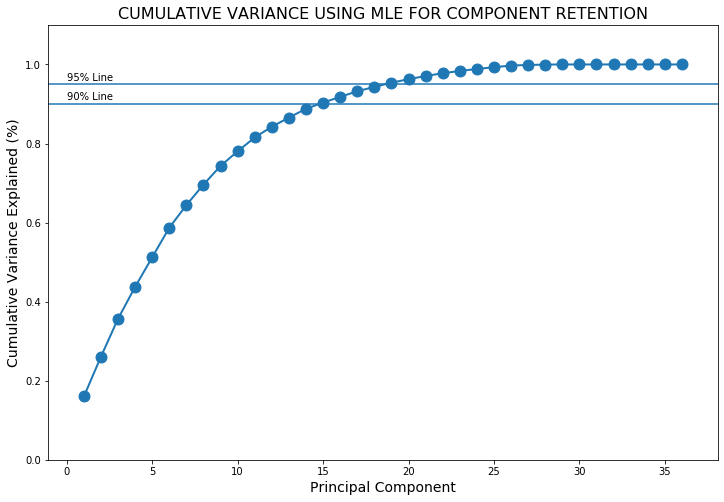

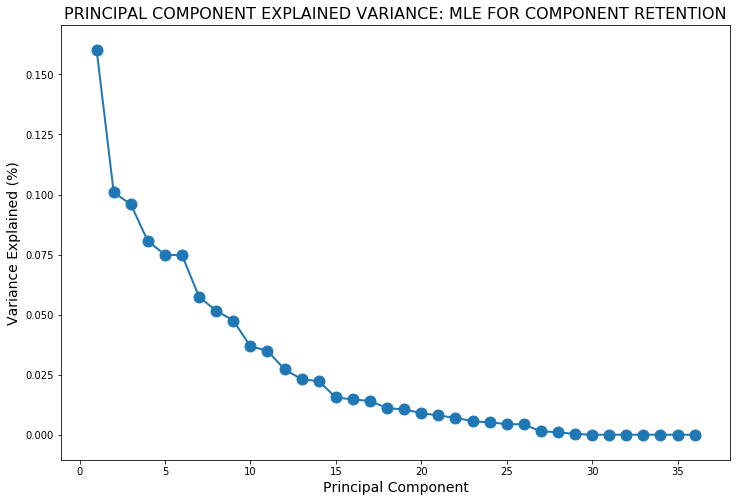

In [27]:
# While we can see the cumluative variance explained in the table above when we add each PC, lets also visualise
# the cumulative variance explained in a plot to help better understand what is occuring in our data  
if isinstance(n_components_output, str):
    title_fig = str('Cumulative Variance Using ' + n_components_output + ' for component retention').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Cumulative Variance using ' + n_components_output + ' components').upper()
else:
    title_fig = str('Cumulative Variance %').upper()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), cum_per.T, lw=2)
ax.scatter(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), cum_per.T, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Principal Component', fontsize=14)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=14)
plt.ylim(0,1.1)
# plt.axvline(x=upper_sale_residual)
plt.axhline(0.90)
plt.axhline(0.95)
plt.text(-0,0.96,'95% Line')
plt.text(-0,0.91,'90% Line')
plt.show()


#This plot is an alternative looking at the variance explained by each individual component. 
if isinstance(n_components_output, str):
    title_fig = str('Principal Component Explained Variance: ' + n_components_output + ' for component retention').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Principal Component Explained Variance: ' + n_components_output + ' components').upper()
else:
    title_fig = str('Explained Variance %').upper()
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), subj_exp_var_pct.T, lw=2)
ax.scatter(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), subj_exp_var_pct.T, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Principal Component', fontsize=14)
ax.set_ylabel('Variance Explained (%)', fontsize=14)
plt.show()

As can be seen, 90% of the variance falls at 15 components (vs 36 in the original), while 95% is at 19. Thus, we can interpret this to mean that using 15 components, we will retain 90% of the original variance in the data set. This can help reduce noise in our data set and improve modelling performance. 

## Gesture Modelling - Creating Training and Testing Sets
I will now model gesture data on the target classes.

<left><img src="https://miro.medium.com/max/2816/1*AVVhcmOs7WCBnpNhqi-L6g.png" width="800" height="100"></left>
<centre>Source: https://medium.com/datadriveninvestor/k-fold-and-other-cross-validation-techniques-6c03a2563f1e</centre>

#### Modelling using Leave One Out (LOO)
Holdout sets are one approach to validation whereby data is broken into a training and testing set, with modelling undertaken on the trianing set and then the model is tested on the testing set to see how it performs. The issue with this approach it that the evaluation can depend on how what data ends in two sets, with some extreme situations meaning that evalulation metrics will be unreliable.

K-fold cross validation is an improved method whereby the data set is broken into a specified number of subsets (k), and then testing is conducted on a holdout. When one of the k subsets is used as a holdout (i.e. for testing), the remaining subsets (k-1) are used for training. The average training error across the k training trials then can be calculated, which will provide a more reliable estimate for how well the model will perfom in the real-world on unseen data. The standard deviation can also provide an indicate of how much variance in performance one can expect. 

As we have a small data-set with only 109 data points, it will be quite difficult when it comes to having enough data points for data modelling and validation. Therefore, I need to select an approach that will maximise the amount of data for modelling while provide an opportunity to assess how the model will perform on a validation data set. 

Leave-one-out (LOO) cross validation is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set. That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point. 

For current purposes, therefore, it would make sense to use LOO and then assess how well the modelling predicts the single holdout case. This way, we will be able to test how well the modelling performs. 

#### Baseline Model
First, lets have a look at the baseline we need to achieve, which we get from the largest class of our target.

In [28]:
print("\nPercent of largest class (baseline):", df_original.target_dummy.value_counts(normalize=True).max())


Percent of largest class (baseline): 0.5229357798165137


We therefore have a baseline of 52.29% to achieve in any modelling (which will be the same for all models).

In [29]:
df_unchanged = df_original.copy()

In [30]:
df_original, df_original_test = train_test_split(df_unchanged, test_size=0.20)

#### Gestures - Variable Setup
First, lets create our X and y variables to model the role that gestures play in deception.

In [31]:
#Create gesture X and y variables
X_gesture = df_original[gesture_variables]
y_gesture = df_original.target_dummy

#### Gestures - Modelling
Now I will model gestures using a number of classification models including:

* **Random Forests**
* **Logistical Regression**
* **K-Nearest Neighbour (kNN)**
* **Support Vector Machine (SVM) Classifier (SVC)**

##### Random Forests

In [32]:
loo=LeaveOneOut()
#For the first model, I will use random forests, with PCA
#Implements the probabilistic PCA model  
pca = PCA(random_state=random_state)
#Implements an empty Random Forest Classification model  
rf = RandomForestClassifier(random_state=random_state)

#Create a pipeline
pipe_gest = make_pipeline(pca,rf)

#####
params_rf = {'pca__n_components': [15,17,19,21],\
             'randomforestclassifier__max_depth':[3,4,5,6,7],\
             'randomforestclassifier__criterion': ['entropy','gini'],\
             'randomforestclassifier__max_features': [3,4,5,6,10]}

# Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_rf = GridSearchCV(pipe_gest,params_rf,verbose=1,n_jobs=-1)

#8.2. Fit the grid_pipe to the training data
grid_pipe_rf.fit(X_gesture,y_gesture)

#Calculate PCA scores for individual cases
pca_transform_scores = grid_pipe_rf.best_estimator_[0].fit_transform(X_gesture)

#8.3 And print out the best paramters to the screen
prediction_class_rf = grid_pipe_rf.predict(X_gesture)
predication_class_rf_prob = grid_pipe_rf.predict_proba(X_gesture)

#Calculate cv scores using leave one out (loo) for on whole data set
cv_scores = cross_val_score(grid_pipe_rf.best_estimator_, X_gesture, y_gesture, cv=loo)

#To see how accurate our predictions are, as we are using LOO and is a binary target,
#we need to specify those cases when the model correctly classified the target and those
#when it did not in order to calculate the accuracy and generate the confusion matrix
cv_df=pd.Series(cv_scores.copy())
cv_df[(cv_scores==0)&(y_gesture.values==0)] = 1
cv_df[(cv_scores==0)&(y_gesture.values==1)] = 0
cv_df[(cv_scores==1)&(y_gesture.values==0)] = 0
cv_df[(cv_scores==1)&(y_gesture.values==1)] = 1

# confusion_matrix(cv_df.values,y_gesture)

print("Best paramters are: ", grid_pipe_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   43.9s finished


Best paramters are:  {'pca__n_components': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 5}


<img src="https://miro.medium.com/max/936/1*pOtBHai4jFd-ujaNXPilRg.png" width="800" height="100">



In [33]:
print("GESTURE - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_rf.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores.mean())
print("Std CV score (using best parameters):", cv_scores.std())
print("\nPerformance across models on LOO case")

print("*****************")
print('\nHoldout set size', len(prediction_class_rf))
print("\nClassification report\n",classification_report(cv_df.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(cv_df.values,y_gesture))

GESTURE - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'pca__n_components': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 5}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.7471264367816092
Std CV score (using best parameters): 0.4346590896825066

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       0.77      0.74      0.76        46
         1.0       0.72      0.76      0.74        41

    accuracy                           0.75        87
   macro avg       0.75      0.75      0.75        87
weighted avg       0.75      0.75      0.75        87


Confusion Matrix
 [[34 12]
 [10 31]]


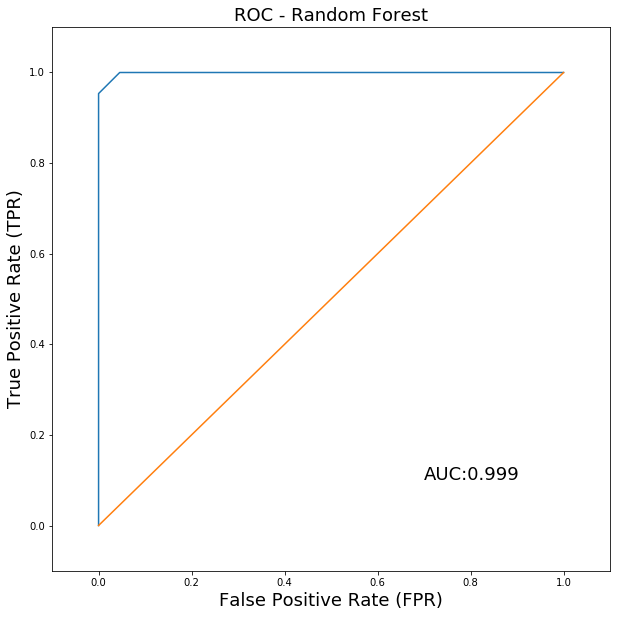

AUC:0.999


In [34]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, predication_class_rf_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Random Forest', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})
plt.show()
print(AUC)

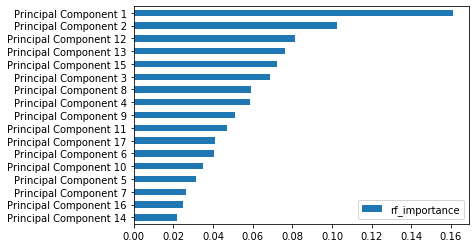

In [35]:
pca_components_list = []

for component in range(0,grid_pipe_rf.best_estimator_[0].n_components):
    to_append = "Principal Component " + str(component +1)
    pca_components_list.append(to_append)

rf_feat_importance = pd.DataFrame(grid_pipe_rf.best_estimator_[-1]\
             .feature_importances_,pca_components_list)\
             .rename(columns={0:'rf_importance'})\


rf_feat_importance.sort_values(by='rf_importance', ascending=True)\
                  .plot(kind='barh')

In [36]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(grid_pipe_rf.best_estimator_[-1].estimators_[grid_pipe_rf.best_index_], out_file='tree.dot', 
                feature_names = rf_feat_importance.index,
                class_names = ['Truthful','Deceptive'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Logistical Regression

In [37]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
random_state = 42

pca_r = PCA(random_state=random_state)
log_r = LogisticRegression(random_state=random_state)

pipe_gest_log_r = make_pipeline(pca_r,log_r)

#####
params_log_r = {'pca__n_components': [15,17,19,21],\
                'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100], 
                'logisticregression__penalty': ['l1','l2','elasticnet']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_log_r = GridSearchCV(pipe_gest_log_r,params_log_r,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_log_r.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_log_r = grid_pipe_log_r.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r = grid_pipe_log_r.predict(X_gesture)
prediction_class_prob_log_r = grid_pipe_log_r.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r = cross_val_score(grid_pipe_log_r.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_loo = cv_scores_log_r.copy()

classification_cv_log_r_loo=pd.Series(classification_cv_log_r_loo)
classification_cv_log_r_loo[(classification_cv_log_r_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_loo[(classification_cv_log_r_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_loo[(classification_cv_log_r_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_loo[(classification_cv_log_r_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_log_r.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    3.9s finished


Best paramters are:  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 15}


In [38]:
print("LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_log_r.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r.mean())
print("Std CV score (using best parameters):", cv_scores_log_r.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r))
print("\nClassification report\n",classification_report(classification_cv_log_r_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_loo.values,y_gesture))

LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 15}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.7701149425287356
Std CV score (using best parameters): 0.4207587406373132

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        55
         1.0       0.74      1.00      0.85        32

    accuracy                           0.87        87
   macro avg       0.87      0.90      0.87        87
weighted avg       0.91      0.87      0.88        87


Confusion Matrix
 [[44 11]
 [ 0 32]]


Text(0.7, 0.1, 'AUC:0.961')

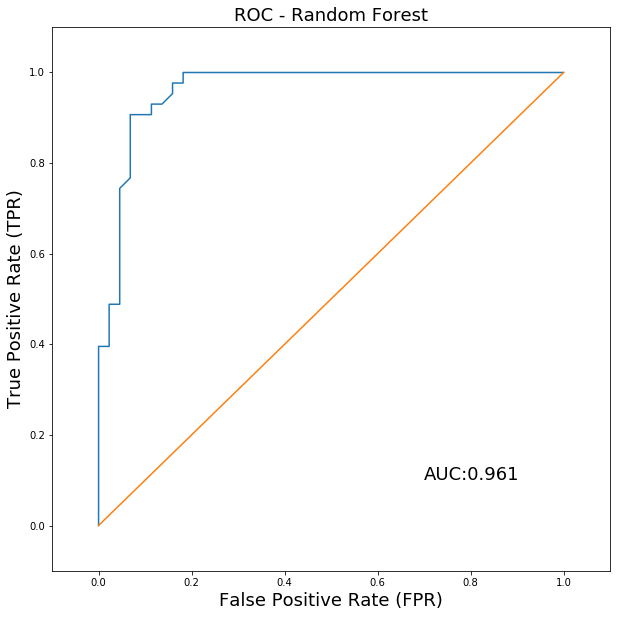

In [39]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_log_r[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Random Forest', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

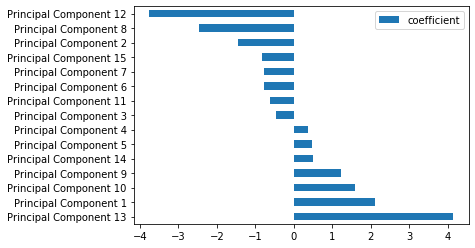

In [40]:
pca_r_components_list = []

for component in range(0,grid_pipe_log_r.best_estimator_[0].n_components):
    to_append = "Principal Component " + str(component +1)
    pca_r_components_list.append(to_append)

log_r_coef = pd.DataFrame(grid_pipe_log_r.best_estimator_[-1]\
             .coef_[0],pca_r_components_list)\
             .rename(columns={0:'coefficient'})\


log_r_coef.sort_values(by='coefficient', ascending=False)\
                  .plot(kind='barh')

#### KNN

In [41]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
random_state = 42

pca_r = PCA(random_state=random_state)
knn = KNeighborsClassifier()

pipe_gest_knn = make_pipeline(pca_r,knn)

#####
params_knn = {'pca__n_components': [15,17,19,21],\
              'kneighborsclassifier__n_neighbors': range(1,30),\
              'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],\
              'kneighborsclassifier__p': [1,2]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_knn = GridSearchCV(pipe_gest_knn,params_knn,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_knn.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_knn = grid_pipe_knn.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_knn = grid_pipe_knn.predict(X_gesture)
prediction_class_probability_knn = grid_pipe_knn.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_knn = cross_val_score(grid_pipe_knn.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_knn_loo = cv_scores_knn.copy()

classification_cv_knn_loo=pd.Series(classification_cv_knn_loo)
classification_cv_knn_loo[(classification_cv_knn_loo==0)&(y_gesture.values==0)] = 1
classification_cv_knn_loo[(classification_cv_knn_loo==0)&(y_gesture.values==1)] = 0
classification_cv_knn_loo[(classification_cv_knn_loo==1)&(y_gesture.values==0)] = 0
classification_cv_knn_loo[(classification_cv_knn_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_knn.best_params_)

Fitting 5 folds for each of 928 candidates, totalling 4640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4640 out of 4640 | elapsed:    9.0s finished


Best paramters are:  {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 2, 'pca__n_components': 15}


In [42]:
print("KNN CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_knn.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_knn.mean())
print("Std CV score (using best parameters):", cv_scores_knn.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_knn))
print("\nClassification report\n",classification_report(classification_cv_knn_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_knn_loo.values,y_gesture))

KNN CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 2, 'pca__n_components': 15}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.7701149425287356
Std CV score (using best parameters): 0.4207587406373132

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.79      0.88        56
         1.0       0.72      1.00      0.84        31

    accuracy                           0.86        87
   macro avg       0.86      0.89      0.86        87
weighted avg       0.90      0.86      0.86        87


Confusion Matrix
 [[44 12]
 [ 0 31]]


#### SVM

In [43]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
random_state = 42

pca_svc = PCA(random_state=random_state)
svc = SVC(probability=True)

pipe_gest_svc = make_pipeline(pca_svc,svc)

# #####
params_svc = {'pca__n_components': [10,17,19,25,30],\
              'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_svc = GridSearchCV(pipe_gest_svc,params_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_svc.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_svc = grid_pipe_svc.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_svc = grid_pipe_svc.predict(X_gesture)
prediction_class_prob_svc = grid_pipe_svc.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_svc = cross_val_score(grid_pipe_svc.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_svc_loo = cv_scores_svc.copy()

classification_cv_svc_loo=pd.Series(classification_cv_svc_loo)
classification_cv_svc_loo[(classification_cv_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_svc_loo[(classification_cv_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_svc_loo[(classification_cv_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_svc_loo[(classification_cv_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_svc.best_params_)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   21.6s finished


Best paramters are:  {'pca__n_components': 17, 'svc__C': 10, 'svc__gamma': 0.0774263682681127, 'svc__kernel': 'rbf'}


In [46]:
print("SVC CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_svc.mean())
print("Std CV score (using best parameters):", cv_scores_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_knn))
print("\nClassification report\n",classification_report(classification_cv_svc_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_svc_loo.values,y_gesture))

SVC CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'pca__n_components': 17, 'svc__C': 10, 'svc__gamma': 0.0774263682681127, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.7816091954022989
Std CV score (using best parameters): 0.4131540403588835

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        55
         1.0       0.74      1.00      0.85        32

    accuracy                           0.87        87
   macro avg       0.87      0.90      0.87        87
weighted avg       0.91      0.87      0.88        87


Confusion Matrix
 [[44 11]
 [ 0 32]]


Text(0, 0.5, 'True Positive Rate (TPR)')

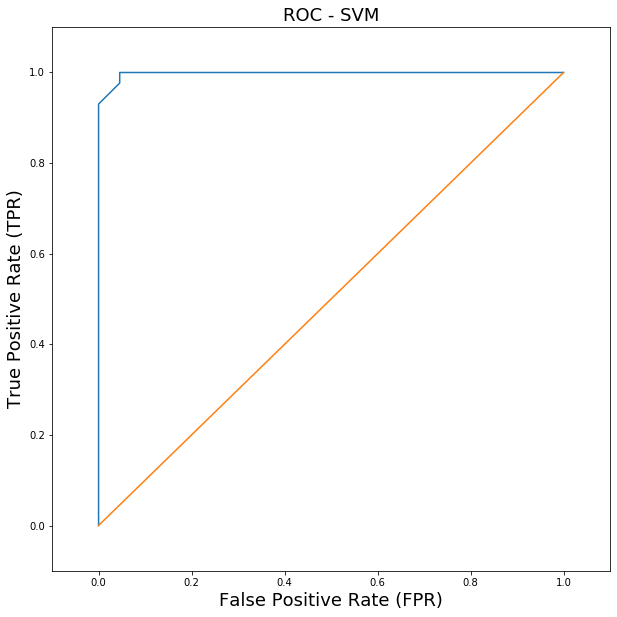

In [47]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

## Vocal Feature Modelling

In [50]:
#Again, lets create some lists of features broken into key areas that we can use in modelling if needed.
#I will create vocal feature counts and time. However, for modelling, I will not include these as they 
#do not make sense to use given the length of speaking time differs across each instance and, thus, features,
#will need to be converted to a comparable time metric to facilitate more appropriate comparisons (such rate
#of speech and ratio of speaking to duration).
vocal_features_counts = ['Count of Syllables',
                         'Count of filler and pauses']
vocal_features_time =   ['Speaking time secs w/o pauses',
                         'Duration time secs w pauses']  

#For modelliling purposes, the following vocal features can be used.
vocal_features_rate =   ['Rate of speech - syb per sec']

vocal_features_ratio =  ['Ratio speaking to duration']

vocal_features_jitter = ['Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp']

vocal_features_FF     = ['Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75']

#All cocal features for X. 
all_vocal_features =    ['Rate of speech - syb per sec',
                         'Ratio speaking to duration',
                         'Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp',
                         'Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75']

all_vocal_features_alt =    ['Rate of speech - syb per sec',
                         'Ratio speaking to duration',
                         'Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp',
                         'Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75',
                         'Pronunciation_posteriori']

df_original['gender_interaction_diff_25_75'] = df_original.Gender_dummy * df_original.diff_25_75


C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [323]:
#To ensure that the test features are are changed in the same way, I will apply the same formula 
df_original_test['gender_interaction_diff_25_75'] = df_original_test.Gender_dummy * df_original_test.diff_25_75

C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
#Create gesture X and y variables
all_vocal_features.append('Gender_dummy')
all_vocal_features.append('gender_interaction_diff_25_75')

X_vocal = df_original[all_vocal_features]
y_vocal = df_original.target_dummy
#And create training and testing class. As we don't have a lot of data for training, 
#lets keep 10% aside as a validation set. However, we will also investigate the best approach

#### Vocal Modelling - Logistic Regression

In [52]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
random_state = 42

log_r_vocal = LogisticRegression(random_state=random_state, max_iter=1000)
pipe_vocal = make_pipeline(StandardScaler(),log_r_vocal)

#####
params_log_r_vocal = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['newton-cg','liblinear','saga']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_vocal = GridSearchCV(pipe_vocal,params_log_r_vocal,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_vocal.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_vocal = grid_log_r_vocal.predict(X_vocal)
prediction_class_prob_log_r_vocal = grid_log_r_vocal.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_vocal = cross_val_score(grid_log_r_vocal.best_estimator_, X_vocal, y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r__vocal_loo = cv_scores_log_r_vocal.copy()

classification_cv_log_r__vocal_loo=pd.Series(classification_cv_log_r__vocal_loo)
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_vocal.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    1.3s finished


Best paramters are:  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}


In [53]:
print("VOCAL - LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_vocal.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_vocal.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_vocal.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_vocal))
print("\nClassification report\n",classification_report(classification_cv_log_r__vocal_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r__vocal_loo.values,y_vocal))

VOCAL - LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.6781609195402298
Std CV score (using best parameters): 0.4671816421356683

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.76      0.86        58
         1.0       0.67      1.00      0.81        29

    accuracy                           0.84        87
   macro avg       0.84      0.88      0.83        87
weighted avg       0.89      0.84      0.84        87


Confusion Matrix
 [[44 14]
 [ 0 29]]


Text(0, 0.5, 'True Positive Rate (TPR)')

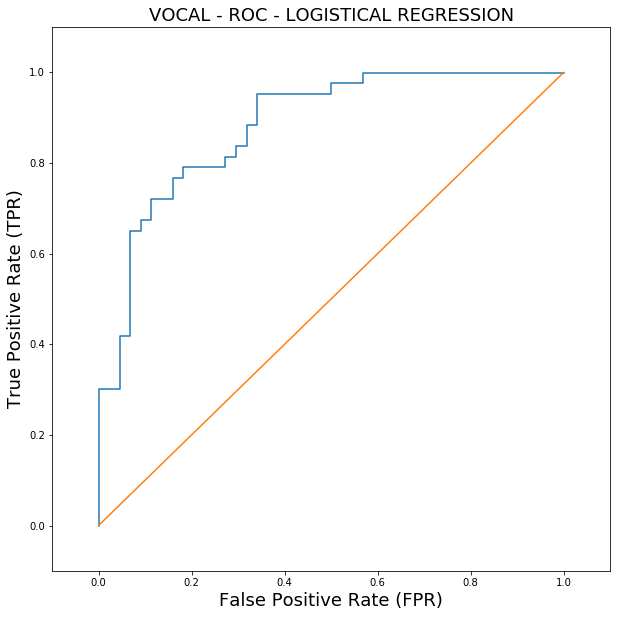

In [54]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_vocal, prediction_class_prob_log_r_vocal[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('VOCAL - ROC - LOGISTICAL REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

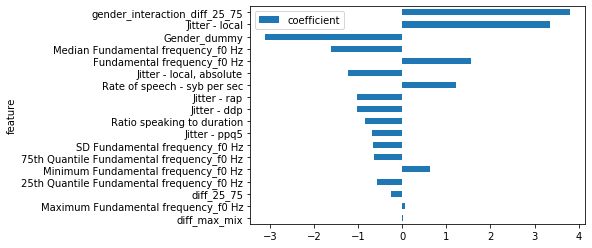

In [56]:
log_r__vocal_coef = pd.DataFrame(grid_log_r_vocal.best_estimator_[-1]\
             .coef_[0],X_vocal.columns)\
             .rename(columns={0:'coefficient'}).reset_index().rename(columns={'index':'feature'})\

log_r__vocal_coef['abs_coefficient'] = abs(log_r__vocal_coef.coefficient)
log_r__vocal_coef.sort_values(by='abs_coefficient', ascending=True).plot.barh(x='feature',y='coefficient')

#### Vocal Modelling - Random Forests

In [57]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
rf_vocal = RandomForestClassifier(random_state=random_state)
pipe_rf_vocal = make_pipeline(StandardScaler(),rf_vocal)

#####
params_rf_vocal = {'randomforestclassifier__max_depth':[2,3,4,5],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [3,4,5,6]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_vocal = GridSearchCV(pipe_rf_vocal,params_rf_vocal,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_vocal.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_vocal = grid_rf_vocal.predict(X_vocal)
prediction_class_prob_rf_vocal = grid_rf_vocal.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_vocal = cross_val_score(grid_rf_vocal.best_estimator_, X_vocal, y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__vocal_loo = cv_scores_rf_vocal.copy()

classification_cv_rf__vocal_loo=pd.Series(classification_cv_rf__vocal_loo)
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_vocal.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.2s finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 4}


In [58]:
print("VOCAL - RANDOM FOREST CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_vocal.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_vocal.mean())
print("Std CV score (using best parameters):", cv_scores_rf_vocal.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_vocal))
print("\nClassification report\n",classification_report(classification_cv_rf__vocal_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__vocal_loo.values,y_vocal))

VOCAL - RANDOM FOREST CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 4}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.6091954022988506
Std CV score (using best parameters): 0.48793069601818684

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.72      0.84        61
         1.0       0.60      1.00      0.75        26

    accuracy                           0.80        87
   macro avg       0.80      0.86      0.80        87
weighted avg       0.88      0.80      0.81        87


Confusion Matrix
 [[44 17]
 [ 0 26]]


Text(0, 0.5, 'True Positive Rate (TPR)')

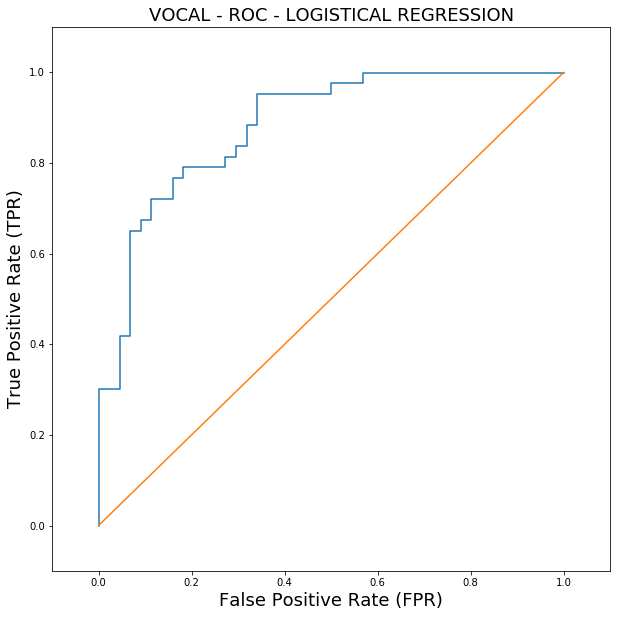

In [59]:
#To help visualise the performance of the random forests model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_vocal, prediction_class_prob_log_r_vocal[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('VOCAL - ROC - LOGISTICAL REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

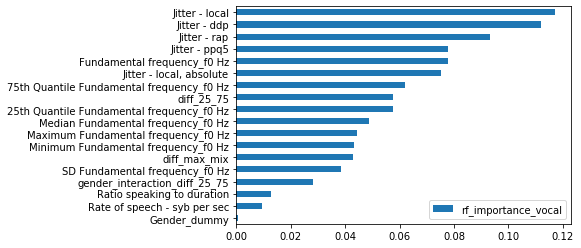

In [60]:
rf_vocal_feat_importance = pd.DataFrame(grid_rf_vocal.best_estimator_[-1].feature_importances_,\
                                        X_vocal.columns)\
                                         .rename(columns={0:'rf_importance_vocal'})\

rf_vocal_feat_importance.sort_values(by='rf_importance_vocal',\
                                     ascending=True)\
                                     .plot(kind='barh')

In [61]:
# Export as dot file
export_graphviz(grid_rf_vocal.best_estimator_[-1].estimators_[grid_rf_vocal.best_index_], out_file='tree.dot', 
                feature_names = rf_vocal_feat_importance.index,
                class_names = ['Truthful','Deceptive'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Vocal Modelling - SVM

In [62]:

random_state = 42

svc_vocal = SVC(probability=True)

pipe_vocal_svc = make_pipeline(StandardScaler(),svc_vocal)

# #####
params_vocal_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_vocal_svc = GridSearchCV(pipe_vocal_svc,params_vocal_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_vocal_svc.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_vocal_svc = grid_pipe_vocal_svc.predict(X_vocal)
prediction_class_vocal_prob_svc = grid_pipe_vocal_svc.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_vocal_svc = cross_val_score(grid_pipe_vocal_svc.best_estimator_, X_vocal,y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_vocal_svc_loo = cv_scores_vocal_svc.copy()

classification_cv_vocal_svc_loo=pd.Series(classification_cv_vocal_svc_loo)
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_vocal_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1995 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    8.4s finished


Best paramters are:  {'svc__C': 100, 'svc__gamma': 0.01291549665014884, 'svc__kernel': 'rbf'}


In [63]:
print("VOCAL - SVM CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_vocal_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_vocal_svc.mean())
print("Std CV score (using best parameters):", cv_scores_vocal_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_vocal_svc))
print("\nClassification report\n",classification_report(classification_cv_vocal_svc_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_vocal_svc_loo.values,y_vocal))

VOCAL - SVM CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'svc__C': 100, 'svc__gamma': 0.01291549665014884, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.7126436781609196
Std CV score (using best parameters): 0.45252918816159826

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        57
         1.0       0.70      1.00      0.82        30

    accuracy                           0.85        87
   macro avg       0.85      0.89      0.85        87
weighted avg       0.90      0.85      0.85        87


Confusion Matrix
 [[44 13]
 [ 0 30]]


Text(0, 0.5, 'True Positive Rate (TPR)')

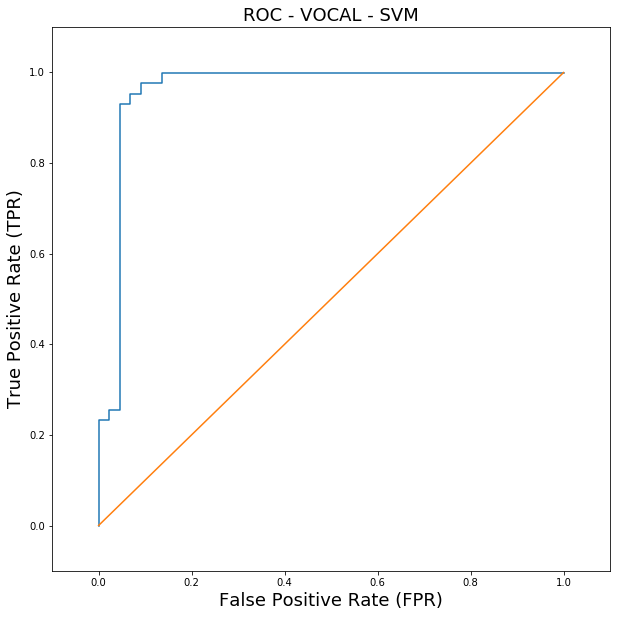

In [65]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_vocal, prediction_class_vocal_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - VOCAL - SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

## Lexical Feature Modelling

#### Parts of Speech (POS)

In [345]:
#Let's first create new working lexical dataframe to work with for the current modelling. 
df_lexical = df_original.copy()
#Drop Gesture variables
df_lexical.drop(gesture_variables,axis=1,inplace=True)
#and then all other vocal feature variables and other features not used. 
df_lexical.drop(['Pronunciation_posteriori', 'Gender', 'Mood_from_mva',
       'Count of Syllables', 'Count of filler and pauses',
       'Rate of speech - syb per sec', 'Duration time secs w pauses',
       'Ratio speaking to duration',
       'Fundamental frequency_f0 Hz', 'SD Fundamental frequency_f0 Hz',
       'Median Fundamental frequency_f0 Hz',
       'Minimum Fundamental frequency_f0 Hz',
       'Maximum Fundamental frequency_f0 Hz',
       '25th Quantile Fundamental frequency_f0 Hz',
       '75th Quantile Fundamental frequency_f0 Hz', 'Jitter - local',
       'Jitter - local, absolute', 'Jitter - rap', 'Jitter - ppq5',
       'Jitter - ddp','pauses_per_minute',
       'log_pauses_per_minute', 'diff_max_mix', 'diff_25_75','target'],axis=1, inplace=True)

In [346]:
#Let's first create new working lexical dataframe to work with for the current modelling. 
df_lexical_test = df_original_test.copy()
#Drop Gesture variables
df_lexical_test.drop(gesture_variables,axis=1,inplace=True)
#and then all other vocal feature variables and other features not used. 
df_lexical_test.drop(['Pronunciation_posteriori', 'Gender', 'Mood_from_mva',
       'Count of Syllables', 'Count of filler and pauses',
       'Rate of speech - syb per sec', 'Duration time secs w pauses',
       'Ratio speaking to duration',
       'Fundamental frequency_f0 Hz', 'SD Fundamental frequency_f0 Hz',
       'Median Fundamental frequency_f0 Hz',
       'Minimum Fundamental frequency_f0 Hz',
       'Maximum Fundamental frequency_f0 Hz',
       '25th Quantile Fundamental frequency_f0 Hz',
       '75th Quantile Fundamental frequency_f0 Hz', 'Jitter - local',
       'Jitter - local, absolute', 'Jitter - rap', 'Jitter - ppq5',
       'Jitter - ddp','pauses_per_minute',
       'log_pauses_per_minute', 'diff_max_mix', 'diff_25_75','target'],axis=1, inplace=True)

In [347]:
X_lexical = df_lexical.transcription.copy()

In [348]:
X_lexical_test = df_original_test.transcription.copy()

As we are interested in use of parts of speech (e.g. personal pronouns), lets first extract the Parts of Speech (POS) information from the transcriptions. To achieve this, I will use TextBlob, which has a POS module (.tags). 

In [349]:
from collections import Counter
#Create a dictionary of Parts of Speech counts to append to original lexical dataframe
pos_dict = {}

for i,x in enumerate(X_lexical):
    textblob_lex = TextBlob(x)
    counts = dict(Counter(tag for word,tag in textblob_lex.tags))
    pos_dict.update({X_lexical.index[i]: counts})

#Create a parts of speech dataframe from the newly created dictionary
pos_df = pd.DataFrame(pos_dict).T

#And then conctenate the lexical and pos_df dataframes
df_lexical = pd.concat([df_lexical,pos_df], axis=1)

In [351]:
#Create a dictionary of Parts of Speech counts to append to original lexical dataframe
pos_dict_test = {}

for i,x in enumerate(X_lexical_test):
    textblob_lex = TextBlob(x)
    counts = dict(Counter(tag for word,tag in textblob_lex.tags))
    pos_dict_test.update({X_lexical.index[i]: counts})

#Create a parts of speech dataframe from the newly created dictionary
pos_df_test = pd.DataFrame(pos_dict_test).T

#And then conctenate the lexical and pos_df dataframes
df_lexical_test = pd.concat([df_lexical_test,pos_df_test], axis=1)



In [357]:
df_lexical_test.columns

Index(['original_video_id', 'transcription', 'Speaking time secs w/o pauses',
       'target_dummy', 'Gender_dummy', 'gender_interaction_diff_25_75', 'RB',
       'PRP', 'VBP', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', 'VBZ', 'PRP$', 'VBD',
       'CC', 'WRB', 'WP', 'JJS', 'NNS', 'VBN', 'VB', 'TO', 'PDT', 'WDT', 'MD',
       'RP', 'VBG', 'UH', 'RBR', 'EX', 'JJR'],
      dtype='object')

In [355]:
df_lexical_test.drop(columns=[['FW', 'NNPS']])

KeyError: "[('FW', 'NNPS')] not found in axis"

In [242]:
#Now we have our POS counts, lets create a columns list to speed things up when masking if needed
pos_columns = ['DT', 'NN', 'PRP', 'VBD', 'RB', 'CC',
               'IN', 'VBN', 'VBG', 'TO', 'WDT', 'VBZ', 'VBP', 'NNS', 'JJ', 'WRB',
               'NNP', 'PRP$', 'VB', 'RP', 'WP', 'MD', 'PDT', 'CD', 'EX', 'RBR', 'JJR',
               'UH', 'JJS', 'FW', 'NNPS']

In [243]:
#As the length of times speaking differ for each row, lets create a pos rate per minute, which will 
#Create a ratio variable for rate of part of speech use (POS Per Minute)
df_lexical = df_lexical.join(df_lexical[pos_columns].apply(lambda x:(df_lexical['Speaking time secs w/o pauses'] /60) * x),rsuffix='_use_per_min')

In [353]:
df_lexical_test = df_lexical_test.join(df_lexical_test[pos_columns].apply(lambda x:(df_lexical_test['Speaking time secs w/o pauses'] /60) * x),rsuffix='_use_per_min')

KeyError: "['FW', 'NNPS'] not in index"

In [352]:
df_lexical_test

original_video_id                                      transcription  \
0                    NaN                                                NaN   
4                    NaN                                                NaN   
5      trial_lie_008.mp4  Ahhh ... I didnt go to the dance club as a dri...   
6                    NaN                                                NaN   
8      trial_lie_011.mp4  Uh, I had just been on a cruise with my husban...   
9      trial_lie_012.mp4  I dont know, maybe ten ... nine thirty, ten, s...   
14                   NaN                                                NaN   
15                   NaN                                                NaN   
17     trial_lie_020.mp4  When I sort a came out of the fog, I realized ...   
18     trial_lie_021.mp4  I do recall him screaming and yelling at me, u...   
19     trial_lie_022.mp4  Well, I think that I have a good memory June 4...   
20     trial_lie_023.mp4  Lying is isnt something typically I just do. I...   
22     trial_lie_025.mp4  as far as details, every detail, I just someti...   
24     trial_lie_027.mp4  The lunging and the gun going off were sort of...   
26     trial_lie_029.mp4  it goes back to the choking incident and the f...   
32                   NaN                                                NaN   
33     trial_lie_037.mp4  He straddled me and he hit me and then he star...   
34                   NaN                                                NaN   
35     trial_lie_039.mp4  I didnt really know her too well, I only saw h...   
37     trial_lie_041.mp4  Remember, we withheld the evidence in this ver...   
41     trial_lie_046.mp4  The first time I remember Mr. Miller he was......   
44                   NaN                                                NaN   
49                   NaN                                                NaN   
50                   NaN                                                NaN   
53                   NaN                                                NaN   
56                   NaN                                                NaN   
63                   NaN                                                NaN   
66   trial_truth_010.mp4  yeah. I, maybe three months in the business, I...   
67                   NaN                                                NaN   
69                   NaN                                                NaN   
71                   NaN                                                NaN   
73   trial_truth_017.mp4  And I am gonna go forward with this ... becaus...   
79   trial_truth_023.mp4  I was convicted the following year and sentenc...   
85                   NaN                                                NaN   
86   trial_truth_032.mp4  And she told me she was, as well. I did when I...   
91                   NaN                                                NaN   
94                   NaN                                                NaN   
95   trial_truth_045.mp4  Um, my daughter and ah, Nicole have been frien...   
96   trial_truth_046.mp4  They were...they were at the taller (?) table ...   
98                   NaN                                                NaN   
100                  NaN                                                NaN   
103  trial_truth_054.mp4  Psychologists once explained to me that societ...   
105                  NaN                                                NaN   
106  trial_truth_057.mp4  I was born in Durango, Colorado. My mother was...   

     Speaking time secs w/o pauses  target_dummy  Gender_dummy  \
0                              NaN           NaN           NaN   
4                              NaN           NaN           NaN   
5                              6.9           1.0           1.0   
6                              NaN           NaN           NaN   
8                             16.1           1.0           0.0   
9                              5.6           1.0       

In [244]:
pos_columns_use_per_min = ['DT_use_per_min', 'NN_use_per_min',
       'PRP_use_per_min', 'VBD_use_per_min', 'RB_use_per_min',
       'CC_use_per_min', 'IN_use_per_min', 'VBN_use_per_min',
       'VBG_use_per_min', 'TO_use_per_min', 'WDT_use_per_min',
       'VBZ_use_per_min', 'VBP_use_per_min', 'NNS_use_per_min',
       'JJ_use_per_min', 'WRB_use_per_min', 'NNP_use_per_min',
       'PRP$_use_per_min', 'VB_use_per_min', 'RP_use_per_min',
       'WP_use_per_min', 'MD_use_per_min', 'PDT_use_per_min', 'CD_use_per_min',
       'EX_use_per_min', 'RBR_use_per_min', 'JJR_use_per_min',
       'UH_use_per_min', 'JJS_use_per_min', 'FW_use_per_min',
       'NNPS_use_per_min']

In [245]:
#Lets inspect the null values
df_lexical[pos_columns_use_per_min].isnull().sum()
#As we are interested in use, we can replace all null values with 0
df_lexical[pos_columns_use_per_min] = df_lexical[pos_columns_use_per_min].fillna(0)

In [246]:
#Lets inspect descriptive statistics of use per minute
df_lexical[pos_columns_use_per_min].describe().T

count      mean       std    min       25%       50%  \
DT_use_per_min     87.0  2.332088  3.733168  0.000  0.481667  1.005000   
NN_use_per_min     87.0  3.859080  5.911483  0.000  0.724167  1.866667   
PRP_use_per_min    87.0  3.762433  5.254448  0.035  0.806667  2.025000   
VBD_use_per_min    87.0  2.615536  4.423400  0.000  0.333333  1.200000   
RB_use_per_min     87.0  1.851398  2.298694  0.000  0.326667  1.005000   
CC_use_per_min     87.0  1.454732  2.705886  0.000  0.200000  0.675000   
IN_use_per_min     87.0  2.854080  4.043433  0.000  0.774167  1.560000   
VBN_use_per_min    87.0  0.392146  0.593788  0.000  0.000000  0.146667   
VBG_use_per_min    87.0  0.624080  1.077642  0.000  0.000000  0.250000   
TO_use_per_min     87.0  0.809023  1.305472  0.000  0.000000  0.325000   
WDT_use_per_min    87.0  0.116954  0.261232  0.000  0.000000  0.000000   
VBZ_use_per_min    87.0  0.403276  0.674213  0.000  0.000000  0.000000   
VBP_use_per_min    87.0  0.935307  1.264580  0.000  0.168333  0.450000   
NNS_use_per_min    87.0  0.723678  1.105597  0.000  0.095833  0.400000   
JJ_use_per_min     87.0  1.307931  1.656797  0.000  0.221667  0.696667   
WRB_use_per_min    87.0  0.267835  0.537275  0.000  0.000000  0.000000   
NNP_use_per_min    87.0  0.871686  1.157840  0.000  0.000000  0.325000   
PRP$_use_per_min   87.0  0.557835  0.986799  0.000  0.000000  0.186667   
VB_use_per_min     87.0  1.102510  1.737089  0.000  0.115833  0.520000   
RP_use_per_min     87.0  0.209061  0.446293  0.000  0.000000  0.000000   
WP_use_per_min     87.0  0.228467  0.535828  0.000  0.000000  0.000000   
MD_use_per_min     87.0  0.209770  0.433378  0.000  0.000000  0.000000   
PDT_use_per_min    87.0  0.052337  0.174276  0.000  0.000000  0.000000   
CD_use_per_min     87.0  0.205690  0.483326  0.000  0.000000  0.000000   
EX_use_per_min     87.0  0.092433  0.237018  0.000  0.000000  0.000000   
RBR_use_per_min    87.0  0.010307  0.070080  0.000  0.000000  0.000000   
JJR_use_per_min    87.0  0.042261  0.192529  0.000  0.000000  0.000000   
UH_use_per_min     87.0  0.180172  0.728156  0.000  0.000000  0.000000   
JJS_use_per_min    87.0  0.017222  0.083602  0.000  0.000000  0.000000   
FW_use_per_min     87.0  0.008774  0.061364  0.000  0.000000  0.000000   
NNPS_use_per_min   87.0  0.023372  0.121199  0.000  0.000000  0.000000   

                       75%        max  
DT_use_per_min    2.444167  22.360000  
NN_use_per_min    4.040000  40.993333  
PRP_use_per_min   4.042500  28.733333  
VBD_use_per_min   3.052500  27.745000  
RB_use_per_min    2.352500  12.111667  
CC_use_per_min    1.546667  18.795000  
IN_use_per_min    3.283333  27.950000  
VBN_use_per_min   0.442500   2.841667  
VBG_use_per_min   0.828333   7.160000  
TO_use_per_min    0.890000   7.160000  
WDT_use_per_min   0.000000   1.070000  
VBZ_use_per_min   0.513333   2.933333  
VBP_use_per_min   1.089167   6.251667  
NNS_use_per_min   0.828333   7.850000  
JJ_use_per_min    1.930833   7.980000  
WRB_use_per_min   0.315833   3.580000  
NNP_use_per_min   1.316667   5.080000  
PRP$_use_per_min  0.489167   4.475000  
VB_use_per_min    1.253333  10.798333  
RP_use_per_min    0.185000   2.355000  
WP_use_per_min    0.267500   3.666667  
MD_use_per_min    0.230000   2.273333  
PDT_use_per_min   0.000000   0.785000  
CD_use_per_min    0.239167   2.795000  
EX_use_per_min    0.000000   1.570000  
RBR_use_per_min   0.000000   0.570000  
JJR_use_per_min   0.000000   1.395000  
UH_use_per_min    0.000000   6.280000  
JJS_use_per_min   0.000000   0.650000  
FW_use_per_min    0.000000   0.521667  
NNPS_use_per_min  0.000000   0.931667

In [247]:
(df_lexical[pos_columns_use_per_min].describe().T['50%'] == 0).sort_values().index

Index(['DT_use_per_min', 'JJ_use_per_min', 'NNS_use_per_min',
       'VBP_use_per_min', 'VB_use_per_min', 'TO_use_per_min',
       'PRP$_use_per_min', 'VBG_use_per_min', 'IN_use_per_min',
       'CC_use_per_min', 'RB_use_per_min', 'VBD_use_per_min',
       'PRP_use_per_min', 'NN_use_per_min', 'VBN_use_per_min',
       'NNP_use_per_min', 'RBR_use_per_min', 'JJS_use_per_min',
       'UH_use_per_min', 'EX_use_per_min', 'JJR_use_per_min', 'CD_use_per_min',
       'WRB_use_per_min', 'MD_use_per_min', 'WP_use_per_min', 'RP_use_per_min',
       'FW_use_per_min', 'VBZ_use_per_min', 'WDT_use_per_min',
       'PDT_use_per_min', 'NNPS_use_per_min'],
      dtype='object')

In [248]:
# #As we have a lot of lot counts, lets drop all features that have a median of 0
# df_lexical.drop(columns =['UH_use_per_min', 'RBR_use_per_min', 'JJR_use_per_min',
#        'JJS_use_per_min', 'CD_use_per_min', 'FW_use_per_min', 'EX_use_per_min',
#        'WRB_use_per_min', 'PDT_use_per_min', 'MD_use_per_min',
#        'WP_use_per_min', 'RP_use_per_min', 'VBZ_use_per_min',
#        'WDT_use_per_min', 'NNPS_use_per_min'], inplace=True)

pos_columns_use_per_min = ['DT_use_per_min', 'JJ_use_per_min', 'NNS_use_per_min',
       'VBP_use_per_min', 'VB_use_per_min', 'TO_use_per_min',
       'PRP$_use_per_min', 'VBG_use_per_min', 'IN_use_per_min',
       'CC_use_per_min', 'RB_use_per_min', 'VBD_use_per_min',
       'PRP_use_per_min', 'NN_use_per_min', 'VBN_use_per_min',
       'NNP_use_per_min']

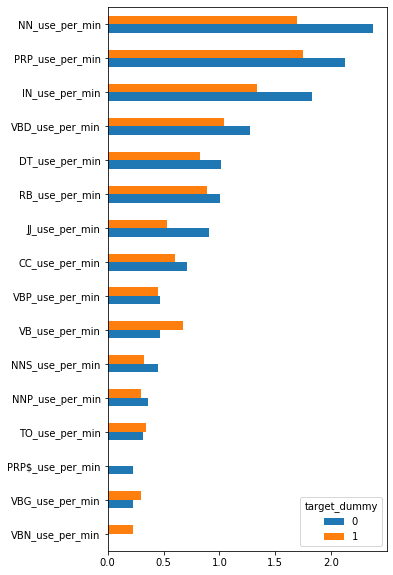

In [249]:
#Lets have a look at the median POS use per minute broken down by target.
df_lexical.groupby(by='target_dummy')[pos_columns_use_per_min].agg(np.median).T.sort_values(by=0).plot(kind='barh', figsize=(5,10),rot=0)
#As can be see, the largest differences between truthful and deceptive statements are on noun use and Prepositions 
#or subordinating conjunctions with truthful statements more associated with increased use of both

### POS Modelling

In [250]:
X_POS = df_lexical[pos_columns_use_per_min].copy()
y_POS = df_lexical.target_dummy.copy()

##### POS Modelling - Logistic Regression

In [251]:
log_r_pos = LogisticRegression(random_state=random_state, max_iter=1000)
pipe_pos = make_pipeline(StandardScaler(),log_r_vocal)

#####
params_log_r_pos = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['liblinear']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_pos = GridSearchCV(pipe_pos,params_log_r_pos,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_pos.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_pos = grid_log_r_pos.predict(X_POS)
prediction_class_prob_log_r_pos = grid_log_r_pos.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_pos = cross_val_score(grid_log_r_pos.best_estimator_, X_POS, y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_POS_loo = cv_scores_log_r_pos.copy()

classification_cv_log_r_POS_loo=pd.Series(classification_cv_log_r_POS_loo)
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_pos.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.4s finished


Best paramters are:  {'logisticregression__C': 0.135, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [252]:
print("POS - LOGISTIC REGRESSION - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_pos.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_pos.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_pos.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_pos))
print("\nClassification report\n",classification_report(classification_cv_log_r_POS_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_POS_loo.values,y_POS))

POS - LOGISTIC REGRESSION - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 0.135, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.5057471264367817
Std CV score (using best parameters): 0.49996696944670216

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        63
         1.0       0.56      1.00      0.72        24

    accuracy                           0.78        87
   macro avg       0.78      0.85      0.77        87
weighted avg       0.88      0.78      0.79        87


Confusion Matrix
 [[44 19]
 [ 0 24]]


Text(0, 0.5, 'True Positive Rate (TPR)')

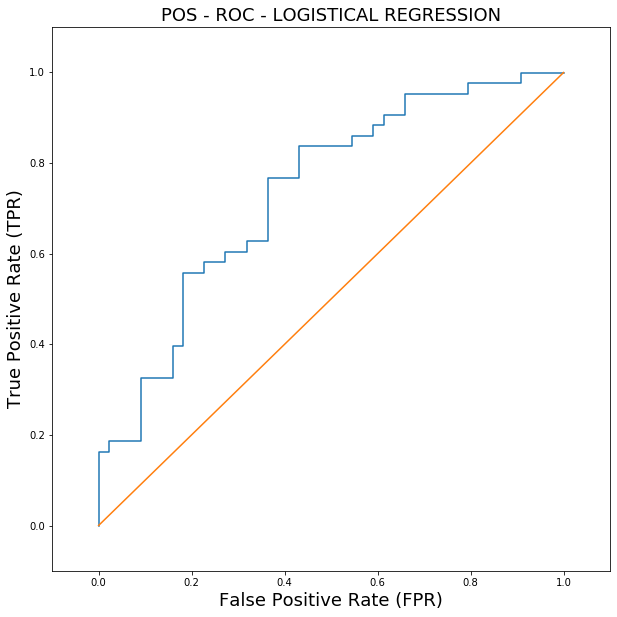

In [253]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_prob_log_r_pos[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS - ROC - LOGISTICAL REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

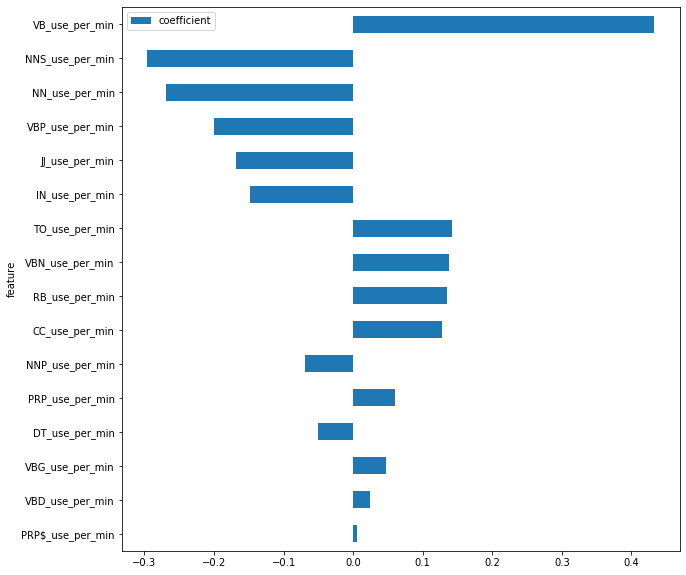

In [254]:
log_r__pos_coef = pd.DataFrame(grid_log_r_pos.best_estimator_[-1]\
             .coef_[0],X_POS.columns)\
             .rename(columns={0:'coefficient'}).reset_index().rename(columns={'index':'feature'})\

log_r__pos_coef['abs_coefficient'] = abs(log_r__pos_coef.coefficient)
log_r__pos_coef.sort_values(by='abs_coefficient', ascending=True).plot.barh(x='feature',y='coefficient', figsize=(10,10))

##### POS - Random Forest

In [255]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
rf_pos = RandomForestClassifier(random_state=random_state)
pipe_rf_pos = make_pipeline(StandardScaler(),rf_pos)

#####
params_rf_pos = {'randomforestclassifier__max_depth':[2,3,4,5],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [3,4,5,6]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_pos = GridSearchCV(pipe_rf_pos,params_rf_pos,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_pos.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_pos = grid_rf_pos.predict(X_POS)
prediction_class_prob_rf_pos = grid_rf_pos.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_pos = cross_val_score(grid_rf_pos.best_estimator_, X_POS, y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__pos_loo = cv_scores_rf_pos.copy()

classification_cv_rf__pos_loo=pd.Series(classification_cv_rf__pos_loo)
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_pos.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.4s finished


Best paramters are:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 5}


In [256]:
print("POS - RANDOM FOREST - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_pos.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_pos.mean())
print("Std CV score (using best parameters):", cv_scores_rf_pos.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_pos))
print("\nClassification report\n",classification_report(classification_cv_rf__pos_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__pos_loo.values,y_POS))

POS - RANDOM FOREST - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 5}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.40229885057471265
Std CV score (using best parameters): 0.49036158638394345

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.62      0.77        71
         1.0       0.37      1.00      0.54        16

    accuracy                           0.69        87
   macro avg       0.69      0.81      0.65        87
weighted avg       0.88      0.69      0.72        87


Confusion Matrix
 [[44 27]
 [ 0 16]]


Text(0, 0.5, 'True Positive Rate (TPR)')

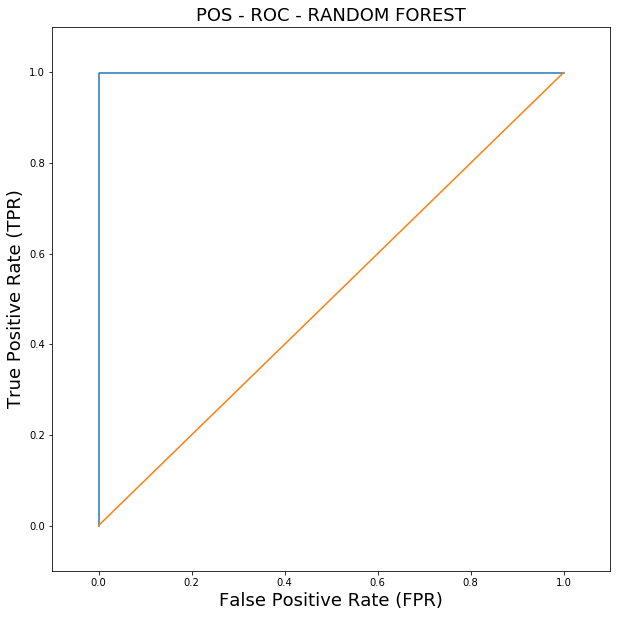

In [257]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_prob_rf_pos[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS - ROC - RANDOM FOREST', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

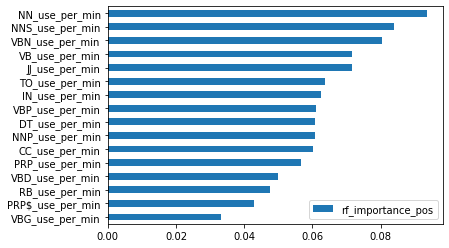

In [258]:
rf_pos_feat_importance = pd.DataFrame(grid_rf_pos.best_estimator_[-1].feature_importances_,\
                                        X_POS.columns)\
                                         .rename(columns={0:'rf_importance_pos'})\

rf_pos_feat_importance.sort_values(by='rf_importance_pos',\
                                     ascending=True)\
                                     .plot(kind='barh')

##### POS - SVM

In [259]:
svc_pos = SVC(probability=True)

pipe_pos_svc = make_pipeline(StandardScaler(),svc_pos)

# #####
params_pos_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_pos_svc = GridSearchCV(pipe_pos_svc,params_pos_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_pos_svc.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_pos_svc = grid_pipe_pos_svc.predict(X_POS)
prediction_class_pos_prob_svc = grid_pipe_pos_svc.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_pos_svc = cross_val_score(grid_pipe_pos_svc.best_estimator_, X_POS,y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_pos_svc_loo = cv_scores_pos_svc.copy()

classification_cv_pos_svc_loo=pd.Series(classification_cv_pos_svc_loo)
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_pos_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    5.3s finished


Best paramters are:  {'svc__C': 0.17, 'svc__gamma': 1e-05, 'svc__kernel': 'linear'}


In [260]:
print("POS - SVM - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_pos_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_pos_svc.mean())
print("Std CV score (using best parameters):", cv_scores_pos_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_pos_svc))
print("\nClassification report\n",classification_report(classification_cv_pos_svc_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_pos_svc_loo.values,y_POS))

POS - SVM - LOO
---------------------------
Best parameters are:  {'svc__C': 0.17, 'svc__gamma': 1e-05, 'svc__kernel': 'linear'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.4827586206896552
Std CV score (using best parameters): 0.4997026464203254

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        57
         1.0       0.70      1.00      0.82        30

    accuracy                           0.85        87
   macro avg       0.85      0.89      0.85        87
weighted avg       0.90      0.85      0.85        87


Confusion Matrix
 [[44 13]
 [ 0 30]]


In [ ]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_pos_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS - SVC - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

### Sentiment

As we also interested use of emotion, TextBlob also has a sentiment tool to extract sentiment. Sentiment is broken into polarity and subjectivity. 

* **Polarity:** is float which lies in the range of -1 to 1 where 1 means positive statement and -1 means a negative statement. 
* **Subjectivity:** is a measure of the degree to which a sentence contains personal opinion, emotion or judgment whereas objective refers to factual information. Highly levels Subjectivity is also a float which lies in the range of 0 to 1.

To achieve this, I will again use TextBlob, which has a sentiment module (.sentiment). 

In [262]:
#Create a dictionary of Sentiment (polarity and subjectivity) to append to original lexical dataframe
sentiment_dict = {}

for i,x in enumerate(X_lexical):
    textblob_sent = TextBlob(x)
    sentiment_dict.update({X_lexical.index[i]:{'polarity': textblob_sent.sentiment[0],
                        'subjectivity': textblob_sent.sentiment[1]}})

#Create a sentiment dataframe from the newly created dictionary
sent_df = pd.DataFrame.from_dict(sentiment_dict, orient='index')

#And then conctenate the lexical and pos_df dataframes
df_lexical = pd.concat([df_lexical,sent_df], axis=1)

In [263]:
#To make things easier, lets create a list of the sentiment columns to work with. 
sentiment_columns = ['polarity', 'subjectivity']

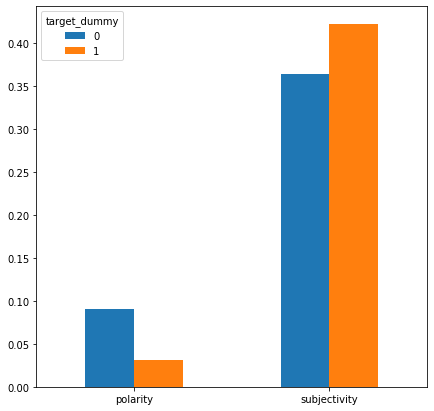

In [268]:
#Lets have a look at the median sentiment between trutuful and deceptive statments
df_lexical.groupby(by='target_dummy')[sentiment_columns].agg(np.median).T.sort_values(by=0).plot(kind='bar', figsize=(7,7),rot=0)
#As can be seen, trutful statements tend to be slightly more positive while deceptive statements tend 
#to have higher levels of subjectiveity indicating highers levels of personal opinion, emotion, or judgement (vs. factual)
#These results align to what we may expect in terms of emotional distancing when being deceptive. Specifically, 
#that those who are deceptive are more likely to use negative terminology (as suggested by lower polarity).
#We may also expect that a lie that represents something that factually didn't occur, would result in higher
#levels of subjectivity as shown by higher subjectivity for those who are deceptive. 

### Sentiment Modelling

In [269]:
X_sentiment = df_lexical[sentiment_columns]
y_sentiment = df_lexical.target_dummy.copy()

#### Logistic Regression

In [270]:
log_r_sentiment = LogisticRegression(random_state=random_state, max_iter=1000)
pipe_sentiment = make_pipeline(StandardScaler(),log_r_sentiment)

#####
params_log_r_sentiment = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['liblinear']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_sentiment = GridSearchCV(pipe_sentiment,params_log_r_sentiment,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_sentiment.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_sentiment = grid_log_r_sentiment.predict(X_sentiment)
prediction_class_prob_log_r_sentiment = grid_log_r_sentiment.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_sentiment = cross_val_score(grid_log_r_sentiment.best_estimator_, X_sentiment, y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_sentiment_loo = cv_scores_log_r_sentiment.copy()

classification_cv_log_r_sentiment_loo=pd.Series(classification_cv_log_r_sentiment_loo)
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_sentiment.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.4s finished


Best paramters are:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [271]:
print("SENTIMENT - LOGISTIC - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_sentiment.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_sentiment.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_sentiment.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_sentiment))
print("\nClassification report\n",classification_report(classification_cv_log_r_sentiment_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_sentiment_loo.values,y_POS))

SENTIMENT - LOGISTIC - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.4482758620689655
Std CV score (using best parameters): 0.49731741730537793

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        73
         1.0       0.33      1.00      0.49        14

    accuracy                           0.67        87
   macro avg       0.66      0.80      0.62        87
weighted avg       0.89      0.67      0.71        87


Confusion Matrix
 [[44 29]
 [ 0 14]]


Text(0, 0.5, 'True Positive Rate (TPR)')

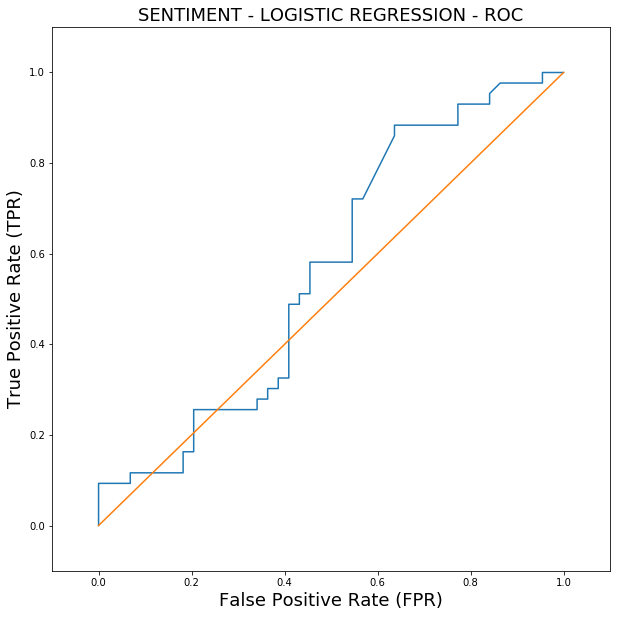

In [272]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_prob_log_r_sentiment[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT - LOGISTIC REGRESSION - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

#### SVM

In [273]:
svc_sentiment = SVC(probability=True)

pipe_sentiment_svc = make_pipeline(StandardScaler(),svc_sentiment)

# #####
params_sentiment_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_sentiment_svc = GridSearchCV(pipe_sentiment_svc,params_sentiment_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_sentiment_svc.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_sentiment_svc = grid_pipe_sentiment_svc.predict(X_sentiment)
prediction_class_sentiment_prob_svc = grid_pipe_sentiment_svc.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_sentiment_svc = cross_val_score(grid_pipe_sentiment_svc.best_estimator_, X_sentiment,y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_sentiment_svc_loo = cv_scores_sentiment_svc.copy()

classification_cv_sentiment_svc_loo=pd.Series(classification_cv_sentiment_svc_loo)
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_sentiment_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1980 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    3.0s finished


Best paramters are:  {'svc__C': 1, 'svc__gamma': 100.0, 'svc__kernel': 'rbf'}


In [274]:
print("SENTIMENT - SVM - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_sentiment_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_sentiment_svc.mean())
print("Std CV score (using best parameters):", cv_scores_sentiment_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_sentiment_svc))
print("\nClassification report\n",classification_report(classification_cv_sentiment_svc_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_sentiment_svc_loo.values,y_POS))

SENTIMENT - SVM - LOO
---------------------------
Best parameters are:  {'svc__C': 1, 'svc__gamma': 100.0, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.6551724137931034
Std CV score (using best parameters): 0.47531202593414545

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.65      0.79        68
         1.0       0.44      1.00      0.61        19

    accuracy                           0.72        87
   macro avg       0.72      0.82      0.70        87
weighted avg       0.88      0.72      0.75        87


Confusion Matrix
 [[44 24]
 [ 0 19]]


Text(0, 0.5, 'True Positive Rate (TPR)')

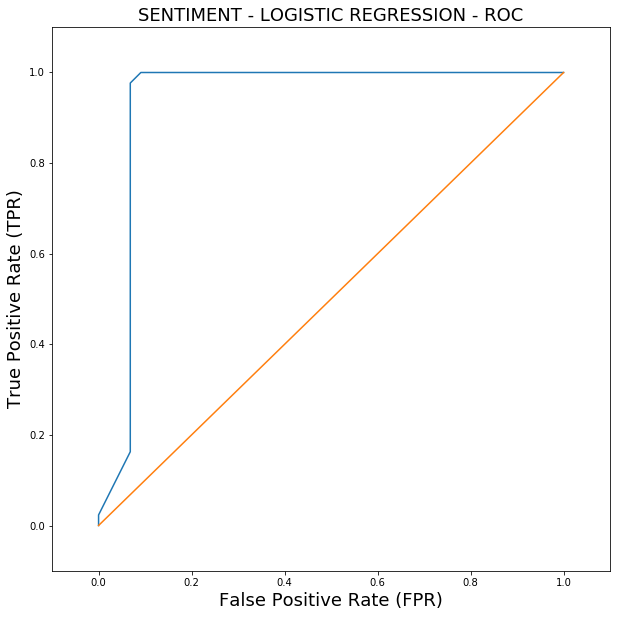

In [275]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_sentiment_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT - LOGISTIC REGRESSION - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

#### Random Forests

In [276]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
rf_sentiment = RandomForestClassifier(random_state=random_state)
pipe_rf_sentiment = make_pipeline(StandardScaler(),rf_sentiment)

#####
params_rf_sentiment = {'randomforestclassifier__max_depth':[1,2],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [1,2]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_sentiment = GridSearchCV(pipe_rf_sentiment,params_rf_sentiment,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_sentiment.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_sentiment = grid_rf_sentiment.predict(X_sentiment)
prediction_class_prob_rf_sentiment = grid_rf_sentiment.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_sentiment = cross_val_score(grid_rf_sentiment.best_estimator_, X_sentiment,y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__sentiment_loo = cv_scores_rf_sentiment.copy()

classification_cv_rf__sentiment_loo=pd.Series(classification_cv_rf__sentiment_loo)
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_sentiment.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 2}


In [277]:
print("SENTIMENT - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_sentiment.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_sentiment.mean())
print("Std CV score (using best parameters):", cv_scores_rf_sentiment.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_sentiment))
print("\nClassification report\n",classification_report(classification_cv_rf__sentiment_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__sentiment_loo.values,y_POS))

SENTIMENT - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 2}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.5862068965517241
Std CV score (using best parameters): 0.4925123054167482

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        62
         1.0       0.58      1.00      0.74        25

    accuracy                           0.79        87
   macro avg       0.79      0.85      0.78        87
weighted avg       0.88      0.79      0.80        87


Confusion Matrix
 [[44 18]
 [ 0 25]]


Text(0, 0.5, 'True Positive Rate (TPR)')

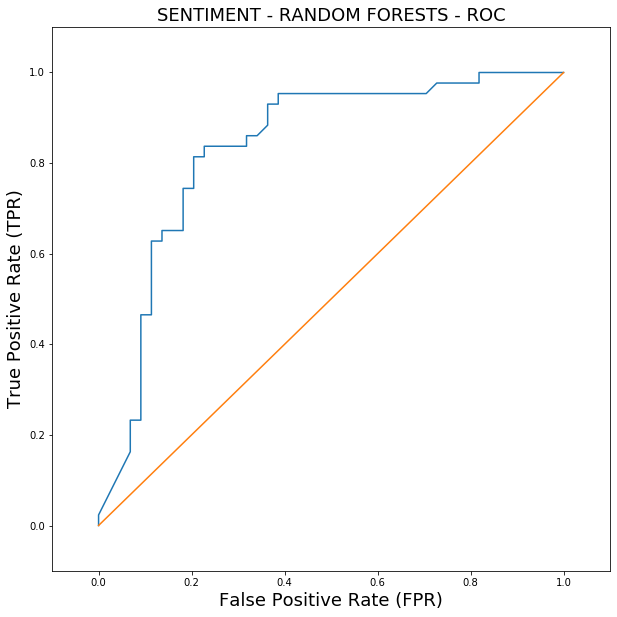

In [278]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_prob_rf_sentiment[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT - RANDOM FORESTS - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

### Bag of Words

In [279]:
X_bow = df_lexical['transcription']
y_bow = df_lexical.target_dummy

##### Bag of Words Modelling - Logistic Regression

In [280]:
standard_stop_words = [] #list(list(ENGLISH_STOP_WORDS) + list(punctuation))

bespoke_stop_words = ['t','d']

final_stop_words = standard_stop_words + bespoke_stop_words


# lexical_tfid = TfidfVectorizer(stop_words=final_stop_words,
#                                ngram_range=(1, 3),
#                                lowercase=True,
#                                token_pattern='\w+',
#                                max_df=109, #<--Max document frequency selected based on size of deceptive class
#                                min_df=4
#                                )

# lexical_tfid_word_matrix = lexical_tfid.fit_transform(df_lexical['bag_of_words'])

# df_lexical_tfid_word_matrix = pd.DataFrame(lexical_tfid_word_matrix.toarray(),columns=lexical_tfid.get_feature_names())

In [281]:
log_reg_bag = LogisticRegression()
tru_SVD_bag  = TruncatedSVD()
bag_tfid = TfidfVectorizer(stop_words=final_stop_words)

pipe_bag_log_r = make_pipeline(bag_tfid,tru_SVD_bag,log_reg_bag)

# #####
params_bag_log_r = {'truncatedsvd__n_components': [5,7,10,12],\
                        'logisticregression__C': [.1,.12,.13,.135,.15,.16,.17,1,3,5,10,11,15],\
                        'tfidfvectorizer__ngram_range': [(1,1),(1,2),(1,3)],\
                        'tfidfvectorizer__min_df': [5,7],\
                        'tfidfvectorizer__max_df': [70,80,90],\
                        'tfidfvectorizer__max_features': [100,125,150,175,200]}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_bag_log_r = GridSearchCV(pipe_bag_log_r,params_bag_log_r,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_bag_log_r.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_bag_log_r = grid_pipe_bag_log_r.predict(X_bow)
prediction_class_bag_prob_log_r = grid_pipe_bag_log_r.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_bag_log_r = cross_val_score(grid_pipe_bag_log_r.best_estimator_, X_bow,y_bow, cv=loo)

classification_cv_log_r_bag_loo = cv_scores_bag_log_r.copy()

classification_cv_log_r_bag_loo=pd.Series(classification_cv_log_r_bag_loo)
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==1)&(y_gesture.values==1)] = 1

print("Best parameters are: ", grid_pipe_bag_log_r.best_params_)

Fitting 5 folds for each of 4680 candidates, totalling 23400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 19200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 23400 out of 23400 | elapsed:  3.3min finished


Best parameters are:  {'logisticregression__C': 0.15, 'tfidfvectorizer__max_df': 80, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 3), 'truncatedsvd__n_components': 7}


In [284]:
print("BAG OF WORDS - LOGISTIC REGRESSION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_bag_log_r.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_bag_log_r.mean())
print("Std CV score (using best parameters):", cv_scores_bag_log_r.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_vocal_svc))
print("\nClassification report\n",classification_report(classification_cv_log_r_bag_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_bag_loo.values,y_vocal))

BAG OF WORDS - LOGISTIC REGRESSION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 0.15, 'tfidfvectorizer__max_df': 80, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 3), 'truncatedsvd__n_components': 7}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.5287356321839081
Std CV score (using best parameters): 0.49917358047375787

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.65      0.79        68
         1.0       0.44      1.00      0.61        19

    accuracy                           0.72        87
   macro avg       0.72      0.82      0.70        87
weighted avg       0.88      0.72      0.75        87


Confusion Matrix
 [[44 24]
 [ 0 19]]


Text(0, 0.5, 'True Positive Rate (TPR)')

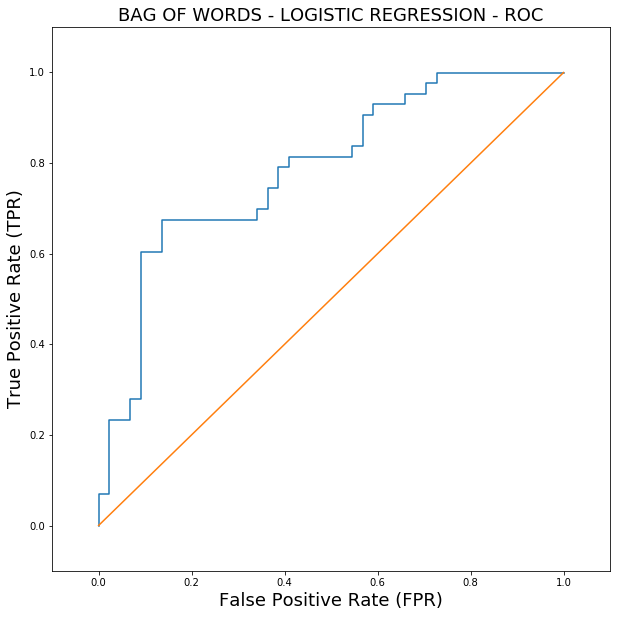

In [285]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_bag_prob_log_r[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS - LOGISTIC REGRESSION - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

##### Bag of Words Modelling - Random Forests

In [287]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
rf_bag = RandomForestClassifier(random_state=random_state)
tru_SVD_bag_rf  = TruncatedSVD()
bag_tfid_rf = TfidfVectorizer(stop_words=final_stop_words)

pipe_rf_bag = make_pipeline(bag_tfid_rf,tru_SVD_bag_rf,rf_bag)

#####
params_rf_bag = {'truncatedsvd__n_components': [5,7,10],\
                 'randomforestclassifier__max_depth':[1,2],\
                 'randomforestclassifier__criterion': ['entropy','gini'],\
                 'randomforestclassifier__max_features': [1,2],
                 'tfidfvectorizer__ngram_range': [(1,1),(1,2)],\
                 'tfidfvectorizer__min_df': [5,7],\
                 'tfidfvectorizer__max_df': [70,100],\
                 'tfidfvectorizer__max_features': [125,150]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_bag = GridSearchCV(pipe_rf_bag,params_rf_bag,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_bag.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_bag = grid_rf_bag.predict(X_bow)
prediction_class_prob_rf_bag = grid_rf_bag.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_bag = cross_val_score(grid_rf_bag.best_estimator_,X_bow,y_bow, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__bag_loo = cv_scores_rf_bag.copy()

classification_cv_rf__bag_loo=pd.Series(classification_cv_rf__bag_loo)
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_bag.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.9min finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 125, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}


In [288]:
print("BAG OF WORDS - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_bag.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_bag.mean())
print("Std CV score (using best parameters):", cv_scores_rf_bag.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_bag))
print("\nClassification report\n",classification_report(classification_cv_rf__bag_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__bag_loo.values,y_vocal))

BAG OF WORDS - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 125, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.5402298850574713
Std CV score (using best parameters): 0.4983789284753746

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.68      0.81        65
         1.0       0.51      1.00      0.68        22

    accuracy                           0.76        87
   macro avg       0.76      0.84      0.74        87
weighted avg       0.88      0.76      0.77  

Text(0, 0.5, 'True Positive Rate (TPR)')

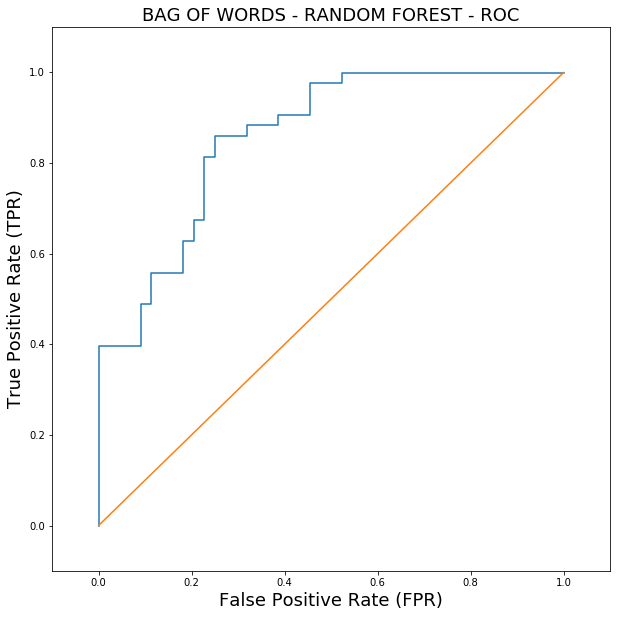

In [289]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_prob_rf_bag[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS - RANDOM FOREST - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

##### Bag of Words Modelling - SVM

In [291]:
svc_bag = SVC(probability=True)
tru_SVD_bag_svc  = TruncatedSVD()
bag_tfid_svc = TfidfVectorizer(stop_words=final_stop_words)

pipe_bag_svc = make_pipeline(bag_tfid_svc,tru_SVD_bag_svc,svc_bag)

# #####
params_bag_svc = {'truncatedsvd__n_components': [5,7,20],\
              'svc__C': [.001,.17,1,3],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf'],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],\
              'tfidfvectorizer__min_df': [5,7],\
              'tfidfvectorizer__max_df': [70,90],\
              'tfidfvectorizer__max_features': [150]}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_bag_svc = GridSearchCV(pipe_bag_svc,params_bag_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_bag_svc.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_bag_svc = grid_pipe_bag_svc.predict(X_bow)
prediction_class_bag_prob_svc = grid_pipe_bag_svc.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_bag_svc = cross_val_score(grid_pipe_bag_svc.best_estimator_, X_bow,y_bow, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_bag_svc_loo = cv_scores_bag_svc.copy()

classification_cv_bag_svc_loo=pd.Series(classification_cv_bag_svc_loo)
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_bag_svc.best_params_)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   43.5s finished


Best paramters are:  {'svc__C': 1, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 2), 'truncatedsvd__n_components': 5}


In [292]:
print("BAG OF WORDS - SVC - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_bag_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_bag_svc.mean())
print("Std CV score (using best parameters):", cv_scores_bag_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_bag_svc))
print("\nClassification report\n",classification_report(classification_cv_bag_svc_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_bag_svc_loo.values,y_vocal))

BAG OF WORDS - SVC - LOO
---------------------------
Best parameters are:  {'svc__C': 1, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 2), 'truncatedsvd__n_components': 5}

*****************

Percent of largest class (baseline): 0.5057471264367817
Average CV score (using best parameters): 0.632183908045977
Std CV score (using best parameters): 0.4822109646759318

Performance across models on LOO case
*****************

Holdout set size 87

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.72      0.84        61
         1.0       0.60      1.00      0.75        26

    accuracy                           0.80        87
   macro avg       0.80      0.86      0.80        87
weighted avg       0.88      0.80      0.81        87


Confusion Matrix
 [[44 17]
 [ 0 26]]


Text(0, 0.5, 'True Positive Rate (TPR)')

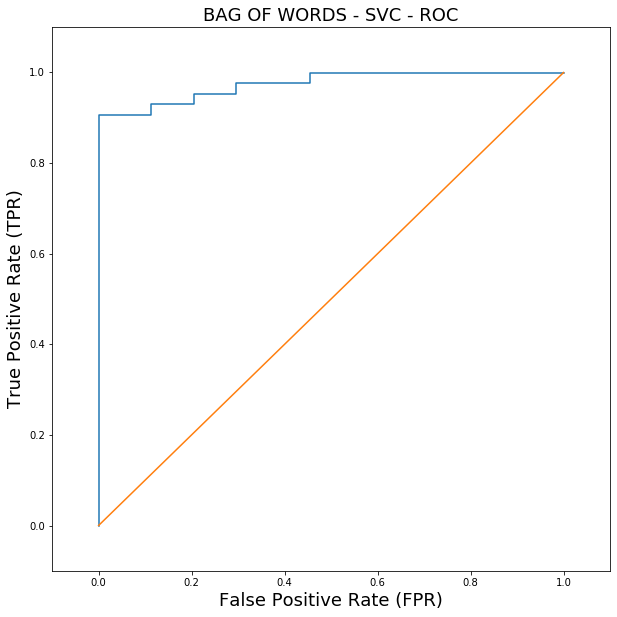

In [293]:
#To help visualise the performance of the SVC model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_POS, prediction_class_bag_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS - SVC - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

# Fusion

In [ ]:
sPLIT 
rUN 5x model on the split data
predict on  test data
take predictions of 5 models on test data
assess accuracy 

In [1691]:
from sklearn.ensemble import VotingClassifier

In [1770]:
# multi_LOO = LeaveOneOut()

# X_train X_test


# for train_index, test_index in multi_LOO.split(df_original):
#     print(train_index, test_index)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108] [0]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108] [1]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28 

In [296]:
#Simple classification voting
fusion_predicted_classes = pd.DataFrame(list(zip(df_original.target_dummy,
         prediction_class_svc,
         prediction_class_vocal_svc,
         prediction_class_pos_svc,
         prediction_class_rf_sentiment,
         prediction_class_bag_svc))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_class_SVC',
                                                    2:'vocal_predicted_class_SVC',
                                                    3:'parts_of_speech_predicted_class_SVC',
                                                    4:'sentiment_predicted_class_rf',
                                                    5:'bag_predicted_class_svc'})

fusion_predicted_classes['average_class'] = (fusion_predicted_classes['gesture_predicted_class_SVC'] +
                                            fusion_predicted_classes['vocal_predicted_class_SVC'] +
                                            fusion_predicted_classes['parts_of_speech_predicted_class_SVC'] +
                                            fusion_predicted_classes['sentiment_predicted_class_rf'] +
                                            fusion_predicted_classes['bag_predicted_class_svc'])/5

fusion_predicted_classes['fusion_predicted_class'] = fusion_predicted_classes['average_class'].apply(lambda x:1 if x >0.50 else 0)

In [297]:
print(classification_report(fusion_predicted_classes['target_true'],fusion_predicted_classes['fusion_predicted_class']))
print(confusion_matrix(fusion_predicted_classes['target_true'],fusion_predicted_classes['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        43

    accuracy                           0.99        87
   macro avg       0.99      0.99      0.99        87
weighted avg       0.99      0.99      0.99        87

[[43  1]
 [ 0 43]]


In [307]:
#Simple classification voting
fusion_predicted_prob = pd.DataFrame(list(zip(df_original.target_dummy,
         prediction_class_prob_svc[:,1],
         prediction_class_vocal_prob_svc[:,1],
         prediction_class_pos_prob_svc[:,1],
         prediction_class_prob_rf_sentiment[:,1],
         prediction_class_bag_prob_svc[:,1]))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_prob_SVC',
                                                    2:'vocal_predicted_prob_SVC',
                                                    3:'parts_of_speech_predicted_prob_SVC',
                                                    4:'sentiment_predicted_prob_rf',
                                                    5:'bag_predicted_prob_SVC'})

fusion_predicted_prob['average_prob'] = (fusion_predicted_prob['gesture_predicted_prob_SVC'] +
                                            fusion_predicted_prob['vocal_predicted_prob_SVC'] +
                                            fusion_predicted_prob['parts_of_speech_predicted_prob_SVC'] +
                                            fusion_predicted_prob['sentiment_predicted_prob_rf'] +
                                            fusion_predicted_prob['bag_predicted_prob_SVC'])/5

fusion_predicted_prob['fusion_predicted_class'] = fusion_predicted_prob['average_prob'].apply(lambda x:1 if x >0.50 else 0)

In [309]:
print(classification_report(fusion_predicted_prob['target_true'],fusion_predicted_prob['fusion_predicted_class']))
print(confusion_matrix(fusion_predicted_prob['target_true'],fusion_predicted_prob['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        43

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87

[[44  0]
 [ 0 43]]


Text(0, 0.5, 'True Positive Rate (TPR)')

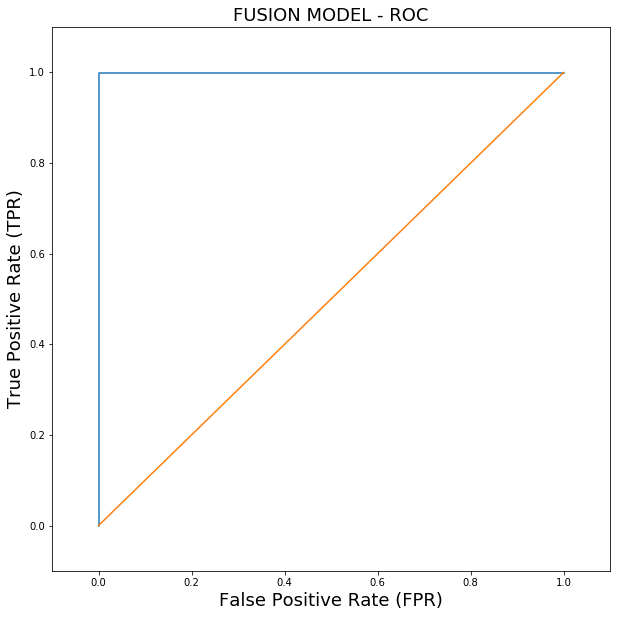

In [310]:
#To help visualise the performance of the SVC model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(fusion_predicted_prob['target_true'], fusion_predicted_prob['average_prob'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('FUSION MODEL - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

In [311]:
df_original_test

original_video_id  OtherGestures  Smile  Laugh  Scowl  \
19     trial_lie_022.mp4              1      0      0      0   
86   trial_truth_032.mp4              1      0      0      0   
96   trial_truth_046.mp4              0      0      0      1   
9      trial_lie_012.mp4              1      0      0      0   
8      trial_lie_011.mp4              0      0      0      1   
103  trial_truth_054.mp4              1      0      0      0   
37     trial_lie_041.mp4              1      0      0      0   
18     trial_lie_021.mp4              1      0      0      0   
17     trial_lie_020.mp4              1      0      0      0   
5      trial_lie_008.mp4              1      0      0      0   
41     trial_lie_046.mp4              1      0      0      0   
66   trial_truth_010.mp4              1      0      0      0   
20     trial_lie_023.mp4              1      0      0      0   
106  trial_truth_057.mp4              1      0      0      0   
35     trial_lie_039.mp4              1      0      0      0   
33     trial_lie_037.mp4              1      0      0      0   
79   trial_truth_023.mp4              1      0      0      0   
73   trial_truth_017.mp4              0      0      0      1   
26     trial_lie_029.mp4              1      0      0      0   
95   trial_truth_045.mp4              1      0      0      0   
24     trial_lie_027.mp4              1      0      0      0   
22     trial_lie_025.mp4              1      0      0      0   

     otherEyebrowMovement  Frown  Raise  OtherEyeMovements  Close-R  ...  \
19                      0      0      1                  1        0  ...   
86                      1      0      0                  0        1  ...   
96                      0      0      1                  0        1  ...   
9                       1      0      0                  1        0  ...   
8                       0      0      1                  0        0  ...   
103                     1      0      0                  0        1  ...   
37                      0      1      0                  0        1  ...   
18                      1      0      0                  1        0  ...   
17                      0      0      1                  1        0  ...   
5                       1      0      0                  1        0  ...   
41                      0      0      1                  1        0  ...   
66                      0      0      1                  0        1  ...   
20                      0      0      1                  1        0  ...   
106                     0      0      1                  0        1  ...   
35                      0      0      1                  0        1  ...   
33                      1      0      0                  0        1  ...   
79                      1      0      0                  0        1  ...   
73                      0      1      0                  1        0  ...   
26                      1      0      0                  1        0  ...   
95                      1      0      0                  0        1  ...   
24                      0      0      1                  1        0  ...   
22                      1      0      0                  1        0  ...   

     Jitter - local, absolute  Jitter - rap  Jitter - ppq5  Jitter - ddp  \
19                   0.000304      0.040940       0.041343      0.122821   
86                   0.000814      0.048867       0.051317      0.146602   
96                   0.000555      0.039002       0.042859      0.117006   
9                    0.000307      0.035536       0.037150      0.106608   
8                    0.000354      0.043184       0.045673      0.129553   
103                  0.000449      0.048564       0.050774      0.145691   
37                   0.000351      0.023865       0.025011      0.071594   
18                   0.000330      0.035698       0.035396      0.107095   
17                   0.000338      0.037607       0.039124      0.112820   
5                    0.00

In [316]:
df_original_test.target_dummy

19     1
86     0
96     0
9      1
8      1
103    0
37     1
18     1
17     1
5      1
41     1
66     0
20     1
106    0
35     1
33     1
79     0
73     0
26     1
95     0
24     1
22     1
Name: target_dummy, dtype: int64

Rate of speech - syb per sec  Ratio speaking to duration  Jitter - local  \
19                            3.0                         0.6        0.075650   
86                            4.0                         1.0        0.092660   
96                            2.0                         0.8        0.075337   
9                             4.0                         0.7        0.065208   
8                             3.0                         0.5        0.080541   
103                           3.0                         0.6        0.093282   
37                            4.0                         0.9        0.049593   
18                            3.0                         0.5        0.067428   
17                            3.0                         0.6        0.072835   
5                             5.0                         0.9        0.077948   
41                            3.0                         0.8        0.086895   
66                            4.0                         0.8        0.078267   
20                            4.0                         0.7        0.083408   
106                           4.0                         0.8        0.045954   
35                            3.0                         0.7        0.069361   
33                            3.0                         0.6        0.073196   
79                            4.0                         0.9        0.048802   
73                            3.0                         0.6        0.064635   
26                            3.0                         0.6        0.073051   
95                            3.0                         0.8        0.076051   
24                            3.0                         0.6        0.071996   
22                            5.0                         0.9        0.068237   

     Jitter - local, absolute  Jitter - rap  Jitter - ppq5  Jitter - ddp  \
19                   0.000304      0.040940       0.041343      0.122821   
86                   0.000814      0.048867       0.051317      0.146602   
96                   0.000555      0.039002       0.042859      0.117006   
9                    0.000307      0.035536       0.037150      0.106608   
8                    0.000354      0.043184       0.045673      0.129553   
103                  0.000449      0.048564       0.050774      0.145691   
37                   0.000351      0.023865       0.025011      0.071594   
18                   0.000330      0.035698       0.035396      0.107095   
17                   0.000338      0.037607       0.039124      0.112820   
5                    0.000425      0.041939       0.042643      0.125818   
41                   0.000432      0.045423       0.050047      0.136268   
66                   0.000609      0.040476       0.045015      0.121429   
20                   0.000414      0.042007       0.041995      0.126021   
106                  0.000195      0.025018       0.023296      0.075053   
35                   0.000314      0.037639       0.041293      0.112917   
33                   0.000339      0.040942       0.043004      0.122827   
79                   0.000264      0.023566       0.023765      0.070699   
73                   0.000388      0.033011       0.034766      0.099032   
26                   0.000339      0.038438       0.039466      0.115313   
95                   0.000381      0.039109       0.040861      0.117326   
24                   0.000324      0.037008       0.038136      0.111023   
22                   0.000305      0.035907       0.036765      0.107722   

     Fundamental frequency_f0 Hz  SD Fundamental frequency_f0 Hz  \
19                        192.67                           40.30   
86                        101.25                           27.36   
96                        118.10                           21.96   
9                         188.51                           30.16   
8                         200.59                    

In [ ]:
grid_pipe_pos_svc.predict()

In [314]:
#Gesture
grid_pipe_svc.predict(df_original_test[gesture_variables])
grid_pipe_svc.predict_proba(df_original_test[gesture_variables])
# #Vocal
grid_pipe_vocal_svc.predict(df_original_test[all_vocal_features])
grid_pipe_vocal_svc.predict_proba(df_original_test[all_vocal_features])
# #Lexical – POS
# prediction_class_pos_svc
# prediction_class_pos_prob_svc
# #Lexical – Sentiment
# prediction_class_rf_sentiment
# prediction_class_prob_rf_sentiment
# #Lexical – Bag of Words
# prediction_class_bag_svc
# prediction_class_bag_prob_svc


array([[0.154191  , 0.845809  ],
       [0.85722829, 0.14277171],
       [0.51659595, 0.48340405],
       [0.19321313, 0.80678687],
       [0.69679431, 0.30320569],
       [0.29661836, 0.70338164],
       [0.58122581, 0.41877419],
       [0.13987801, 0.86012199],
       [0.59436409, 0.40563591],
       [0.82107558, 0.17892442],
       [0.46510339, 0.53489661],
       [0.6083972 , 0.3916028 ],
       [0.154191  , 0.845809  ],
       [0.9232407 , 0.0767593 ],
       [0.74811776, 0.25188224],
       [0.18517133, 0.81482867],
       [0.88710416, 0.11289584],
       [0.57454548, 0.42545452],
       [0.06833783, 0.93166217],
       [0.6974076 , 0.3025924 ],
       [0.42691087, 0.57308913],
       [0.06833783, 0.93166217]])